### Imports

In [3]:
%load_ext autoreload
%autoreload 2

from openaq_anomaly_prediction.config import Configuration as config
from openaq_anomaly_prediction.utils.logging import logger, ProgressLogger
from openaq_anomaly_prediction.load.openaq import client as openaq, AreaDownloader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Area data

In [4]:
new_delhi = AreaDownloader(area_name="new_delhi")
new_delhi.load_bbox(76.772461, 28.161110, 77.768372, 28.943516)

logger.info(f"Area: {new_delhi.area_name.upper()}")
logger.info(f"Locations: {new_delhi.locations.shape}")
logger.info(f"Sensors: {new_delhi.sensors.shape}")

# display(new_delhi.locations.head(1))
# display(new_delhi.sensors.head(1))
# display(new_delhi.instruments.head(1))
# logger.info(f"Instruments: {new_delhi.instruments.shape}")>

00:25:21     INFO |  Area: NEW_DELHI
00:25:21     INFO |  Locations: (107, 27)
00:25:21     INFO |  Sensors: (1241, 7)


In [5]:
# 2 locations have no datetimeFirst/Last, no measurements available for their sensors
print(new_delhi.locations["datetimeFirst.utc"].isna().sum())
print(new_delhi.locations["datetimeLast.utc"].isna().sum())

2
2


Total number of sensors (no filtering): 1241


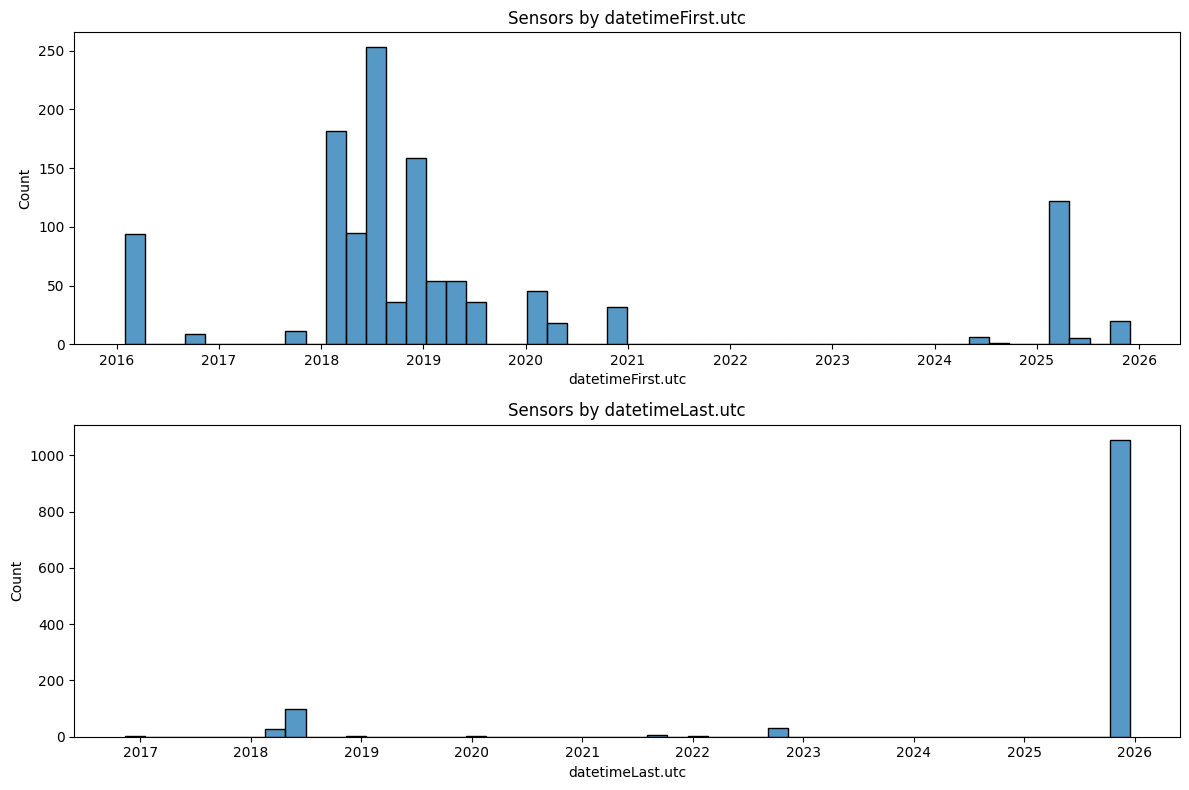

In [6]:
# Plot the distribution of sensors by their location's datetimeFirst.utc and datetimeLast.utc
sensors_with_dates = new_delhi.get_sensors_with_dates()
print(f"Total number of sensors (no filtering): {len(sensors_with_dates)}")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.histplot(sensors_with_dates, x="datetimeFirst.utc", bins=50, ax=axes[0])
axes[0].set_title("Sensors by datetimeFirst.utc")
sns.histplot(sensors_with_dates, x="datetimeLast.utc", bins=50, ax=axes[1])
axes[1].set_title("Sensors by datetimeLast.utc")
plt.tight_layout()
plt.show()

Sensors after date filtering: 1056


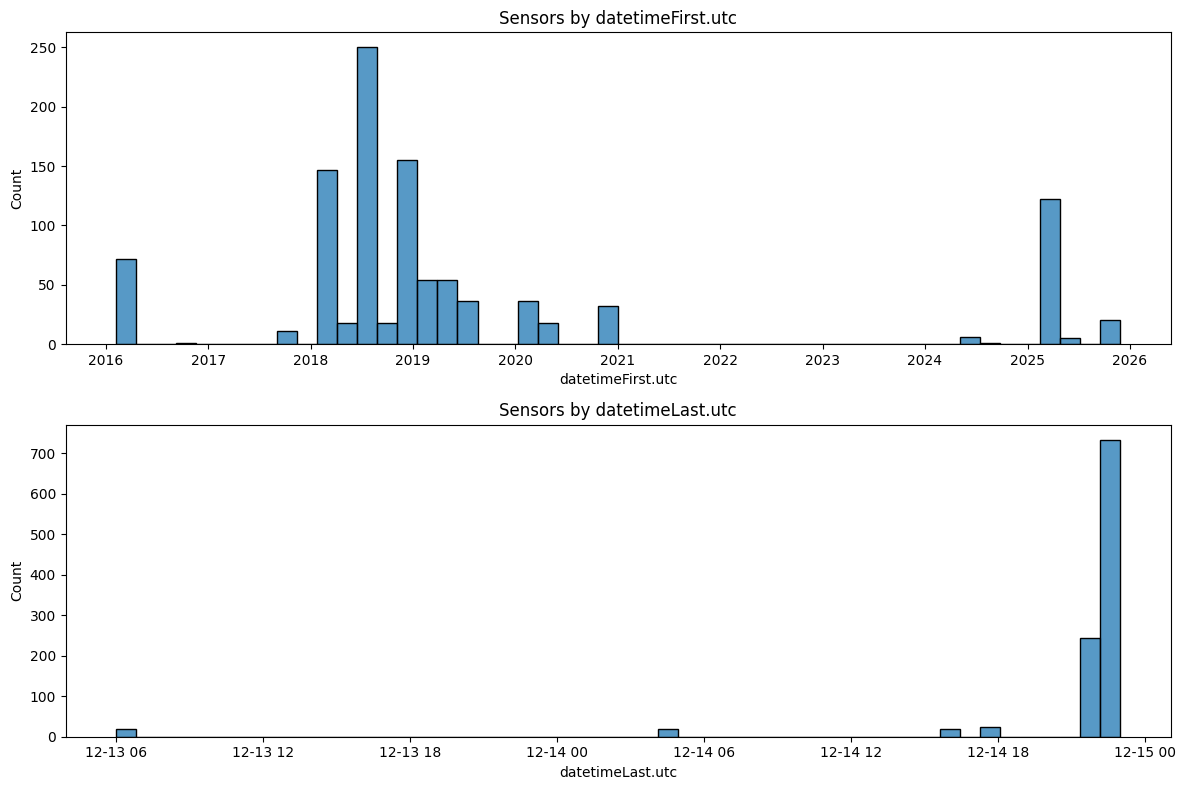

In [7]:
# Filter sensors by date range (only active locations for the date range)
from_date = "2025-01-01T00:00:00+00:00"
to_date = "2025-12-31T23:59:59+00:00"

sensors_with_filters = new_delhi.get_sensors_with_dates(from_date=from_date, to_date=to_date)
print(f"Sensors after date filtering: {len(sensors_with_filters)}")

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.histplot(sensors_with_filters, x="datetimeFirst.utc", bins=50, ax=axes[0])
axes[0].set_title("Sensors by datetimeFirst.utc")
sns.histplot(sensors_with_filters, x="datetimeLast.utc", bins=50, ax=axes[1])
axes[1].set_title("Sensors by datetimeLast.utc")
plt.tight_layout()
plt.show()

### Prepare Downloads

In [9]:
# from openaq_anomaly_prediction.utils.helpers import get_monthly_periods
# get_monthly_periods(2025)[::-1]

In [10]:
# from openaq_anomaly_prediction.utils.helpers import get_monthly_periods, concatenate_csv_files
# from datetime import datetime
# import os

# monthly_period_2025 = get_monthly_periods(2025)
# datetime_from =  monthly_period_2025[0][0]
# datetime_to = monthly_period_2025[2][1]
# # datetime_from = "2016-01-01T00:00:00+00:00"
# # datetime_to = "2017-12-31T23:59:59+00:00"

# datetime_from_str = datetime.fromisoformat(datetime_from).strftime("%Y-%m-%d")
# datetime_to_str = datetime.fromisoformat(datetime_to).strftime("%Y-%m-%d")

# prefix_csv = "new_delhi_2025"

# LOCAL_CSV_DIR = os.path.join(config.DATA_PATH, prefix_csv)
# os.makedirs(LOCAL_CSV_DIR, exist_ok=True)

# concatenated_filename = f"{prefix_csv}_all_sensors_{datetime_from_str}_{datetime_to_str}.csv"

# logger.info(f"PROJECT NAME: {prefix_csv}")
# logger.trace(f"Path: {LOCAL_CSV_DIR}")
# logger.trace(f"Filename: {concatenated_filename}")
# logger.trace(f"From: {datetime_from}, to: {datetime_to}")

### Download from API

In [ ]:
# from datetime import datetime, timezone
# import time
# from typing import Any

# from openaq_anomaly_prediction.utils.helpers import (
#     exec_time,
#     get_iso_now,
#     get_parquet_filepaths,
#     parquets_to_csv,
# )

# ---------------------------------------------------------------------

In [9]:
# --------------------------------------------------------------------------------------
# DOWNLOAD FROM OPENAQ API: Download measurements for filtered sensors in the date range

from openaq_anomaly_prediction.utils.helpers import get_trimestrial_periods

# Testing: clear rate limits
openaq.clear_ratelimits()

all_logs = []
years = [2020, 2021, 2022, 2023]
for year in years:
    # Get trimesters for the year
    trimesters = get_trimestrial_periods(year)

    for i, trimester in enumerate(trimesters):
        datetime_from = trimester[0]
        datetime_to = trimester[1]

        run_id_prefix = f"new_delhi_{year}_T{i + 1}"

        trimester_logs = new_delhi.download_period_from_area(
            datetime_from=datetime_from,
            datetime_to=datetime_to,
            run_id_prefix=run_id_prefix,
            run_label=f"T{i + 1}/{year}",
        )
        all_logs.append(trimester_logs)

00:25:49     INFO |  [OPENAQ] Fetching all measurements for [NEW_DELHI][T1/2020]...
00:25:49    DEBUG |  [START] Downloading data for 912 sensors...
00:25:49    TRACE |   󰘍 RUN_ID: new_delhi_2020_T1_2020-01-01_2020-03-31
00:25:49    TRACE |   󰘍 From: 2020-01-01T00:00:00+00:00, to: 2020-03-31T23:59:59+00:00
00:25:49    1/912 |   󰘍 ----  none                       T1/2020 [sensor_id=392]      | 0.38s: -> usd:2, rem:58, rst:31s
00:25:50    2/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234782] | 0.38s: -> usd:3, rem:57, rst:31s
00:25:50    3/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234783] | 0.37s: -> usd:4, rem:56, rst:30s
00:25:50    4/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234784] | 0.19s: -> usd:5, rem:55, rst:30s
00:25:51    5/912 |   󰘍 ----  none                       T1/2020 [sensor_id=36]       | 0.21s: -> usd:6, rem:54, rst:30s
00:25:51    6/912 |   󰘍 ----  none                       T1/2020 [sensor_id=14340713] |

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


00:28:22  146/912 |   󰘍 100%: 2042/2042 measurements     T1/2020 [sensor_id=15107]    | 3.58s: -> usd:20, rem:40, rst:41s
00:28:25  147/912 |   󰘍 100%: 1981/1981 measurements     T1/2020 [sensor_id=14916]    | 2.36s: -> usd:22, rem:38, rst:39s
00:28:25  148/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234739] | 0.36s: -> usd:23, rem:37, rst:37s
00:28:25  149/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234740] | 0.20s: -> usd:24, rem:36, rst:37s
00:28:26  150/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234741] | 0.36s: -> usd:25, rem:35, rst:37s
00:28:28  151/912 |   󰘍 100%: 1981/1981 measurements     T1/2020 [sensor_id=14919]    | 2.55s: -> usd:27, rem:33, rst:35s
00:28:28  152/912 |   󰘍 ----  none                       T1/2020 [sensor_id=14341688] | 0.19s: -> usd:28, rem:32, rst:34s
00:28:28  153/912 |   󰘍 ----  none                       T1/2020 [sensor_id=12234742] | 0.19s: -> usd:29, rem:31, rst:34s
00:28:31  154/912 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:02:30  663/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235293] | 0.21s: -> usd:28, rem:32, rst:44s
01:02:32  664/909 |   󰘍 100%: 850/850 measurements       T2/2020 [sensor_id=36391]    | 2.20s: -> usd:29, rem:31, rst:44s
01:02:33  665/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235294] | 0.38s: -> usd:30, rem:30, rst:42s
01:02:33  666/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235295] | 0.21s: -> usd:31, rem:29, rst:41s
01:02:33  667/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235296] | 0.36s: -> usd:32, rem:28, rst:41s
01:02:34  668/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235297] | 0.21s: -> usd:33, rem:27, rst:41s
01:02:34  669/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340809] | 0.20s: -> usd:34, rem:26, rst:41s
01:02:34  670/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340810] | 0.21s: -> usd:35, rem:25, rst:40s
01:02:35  671/909 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:06:10  841/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235094] | 0.19s: -> usd:18, rem:42, rst:50s
01:06:10  842/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235095] | 0.22s: -> usd:19, rem:41, rst:50s
01:06:10  843/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340767] | 0.22s: -> usd:20, rem:40, rst:49s
01:06:11  844/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340768] | 0.21s: -> usd:21, rem:39, rst:49s
01:06:13  845/909 |   󰘍 100%: 1208/1208 measurements     T2/2020 [sensor_id=36534]    | 2.03s: -> usd:23, rem:37, rst:48s
01:06:13  846/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14516015] | 0.21s: -> usd:24, rem:36, rst:47s
01:06:13  847/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14728527] | 0.21s: -> usd:25, rem:35, rst:47s
01:06:13  848/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14573420] | 0.20s: -> usd:26, rem:34, rst:46s
01:06:15  849/909 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:07:12  891/909 |   󰘍 100%: 881/881 measurements       T2/2020 [sensor_id=36675]    | 0.82s: -> usd:20, rem:40, rst:49s
01:07:13  892/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235770] | 0.20s: -> usd:21, rem:39, rst:49s
01:07:13  893/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235771] | 0.21s: -> usd:22, rem:38, rst:48s
01:07:13  894/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235772] | 0.21s: -> usd:23, rem:37, rst:48s
01:07:16  895/909 |   󰘍 100%: 1007/1007 measurements     T2/2020 [sensor_id=36676]    | 2.46s: -> usd:25, rem:35, rst:46s
01:07:16  896/909 |   󰘍 ----  none                       T2/2020 [sensor_id=12235773] | 0.20s: -> usd:26, rem:34, rst:45s
01:07:16  897/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340906] | 0.21s: -> usd:27, rem:33, rst:45s
01:07:16  898/909 |   󰘍 ----  none                       T2/2020 [sensor_id=14340907] | 0.20s: -> usd:28, rem:32, rst:45s
01:07:17  899/909 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:18:35  575/909 |   󰘍 100%: 1010/1010 measurements     T3/2020 [sensor_id=20407]    | 2.12s: -> usd:50, rem:10, rst:34s
01:18:36  576/909 |   󰘍 100%: 936/936 measurements       T3/2020 [sensor_id=20411]    | 0.80s: -> usd:51, rem:9, rst:34s
01:18:37  577/909 |   󰘍 100%: 1004/1004 measurements     T3/2020 [sensor_id=20408]    | 1.39s: -> usd:53, rem:7, rst:32s
01:18:37  578/909 |   󰘍 Fetching measurements...         T3/2020 [sensor_id=23669]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:18:38  578/909 |   󰘍 100%: 105/105 measurements       T3/2020 [sensor_id=23669]    | 0.29s: -> usd:54, rem:6, rst:32s
01:18:38  579/909 |   󰘍 100%: 107/107 measurements       T3/2020 [sensor_id=23465]    | 0.29s: -> usd:55, rem:5, rst:31s
01:18:38  580/909 |   󰘍 100%: 113/113 measurements       T3/2020 [sensor_id=34750]    | 0.28s: -> usd:56, rem:4, rst:31s
01:18:38  581/909 |   󰘍 Fetching measurements...         T3/2020 [sensor_id=23534]
01:18:38  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 31 seconds.
01:19:14  581/909 |   󰘍 100%: 1870/1870 measurements     T3/2020 [sensor_id=23534]    | 35.71s: -> usd:2, rem:58, rst:58s
01:19:14  582/909 |   󰘍 100%: 312/312 measurements       T3/2020 [sensor_id=23993]    | 0.42s: -> usd:3, rem:57, rst:56s
01:19:15  583/909 |   󰘍 ----  none                       T3/2020 [sensor_id=12235024] | 0.36s: -> usd:4, rem:56, rst:56s
01:19:15  584/909 |   󰘍 ----  none                       T3/2020 [sensor_id=12235025] | 0

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:19  148/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234739] | 0.21s: -> usd:31, rem:29, rst:45s
01:46:20  149/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234740] | 0.20s: -> usd:32, rem:28, rst:45s
01:46:20  150/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234741] | 0.37s: -> usd:33, rem:27, rst:44s
01:46:23  151/941 |   󰘍 100%: 1003/1003 measurements     T1/2021 [sensor_id=14919]    | 2.62s: -> usd:35, rem:25, rst:42s
01:46:23  152/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=14341688]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:23  152/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341688] | 0.36s: -> usd:36, rem:24, rst:41s
01:46:23  153/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234742] | 0.36s: -> usd:37, rem:23, rst:41s
01:46:25  154/941 |   󰘍 100%: 1003/1003 measurements     T1/2021 [sensor_id=14920]    | 1.77s: -> usd:39, rem:21, rst:40s
01:46:25  155/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234743]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:25  155/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234743] | 0.21s: -> usd:40, rem:20, rst:39s
01:46:28  156/941 |   󰘍 100%: 1003/1003 measurements     T1/2021 [sensor_id=34957]    | 2.64s: -> usd:42, rem:18, rst:37s
01:46:28  157/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234744]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:28  157/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234744] | 0.23s: -> usd:43, rem:17, rst:36s
01:46:30  158/941 |   󰘍 100%: 1003/1003 measurements     T1/2021 [sensor_id=14922]    | 2.03s: -> usd:45, rem:15, rst:34s
01:46:30  159/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234745]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:30  159/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234745] | 0.21s: -> usd:46, rem:14, rst:34s
01:46:32  160/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=14923]    | 1.73s: -> usd:48, rem:12, rst:33s
01:46:32  161/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234746]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:32  161/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234746] | 0.23s: -> usd:49, rem:11, rst:32s
01:46:33  162/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234747] | 0.21s: -> usd:50, rem:10, rst:32s
01:46:33  163/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341690] | 0.22s: -> usd:51, rem:9, rst:32s
01:46:33  164/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341692] | 0.21s: -> usd:52, rem:8, rst:31s
01:46:33  165/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234755] | 0.21s: -> usd:53, rem:7, rst:31s
01:46:35  166/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=14933]    | 1.80s: -> usd:55, rem:5, rst:30s
01:46:35  167/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234756]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:46:35  167/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234756] | 0.20s: -> usd:56, rem:4, rst:29s
01:46:35  168/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234757]
01:46:35  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 29 seconds.
01:47:06  168/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234757] | 30.39s: -> usd:1, rem:59, rst:60s
01:47:08  169/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=14941]    | 1.95s: -> usd:3, rem:57, rst:58s
01:47:08  170/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=14340704]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:08  170/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14340704] | 0.37s: -> usd:4, rem:56, rst:58s
01:47:08  171/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234758] | 0.38s: -> usd:5, rem:55, rst:57s
01:47:10  172/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=14949]    | 1.99s: -> usd:7, rem:53, rst:56s
01:47:10  173/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=14974]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:13  173/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=14974]    | 2.34s: -> usd:9, rem:51, rst:53s
01:47:13  174/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234759]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:13  174/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234759] | 0.22s: -> usd:10, rem:50, rst:53s
01:47:13  175/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234760] | 0.37s: -> usd:11, rem:49, rst:52s
01:47:15  176/941 |   󰘍 100%: 1001/1001 measurements     T1/2021 [sensor_id=14985]    | 1.74s: -> usd:13, rem:47, rst:51s
01:47:15  177/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234761]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:15  177/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234761] | 0.38s: -> usd:14, rem:46, rst:50s
01:47:16  178/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234762] | 0.41s: -> usd:15, rem:45, rst:50s
01:47:18  179/941 |   󰘍 100%: 1002/1002 measurements     T1/2021 [sensor_id=17766]    | 1.81s: -> usd:17, rem:43, rst:48s
01:47:18  180/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234763]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:18  180/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234763] | 0.20s: -> usd:18, rem:42, rst:48s
01:47:18  181/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14340705] | 0.39s: -> usd:19, rem:41, rst:47s
01:47:19  182/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14340706] | 0.21s: -> usd:20, rem:40, rst:47s
01:47:20  183/941 |   󰘍 100%: 802/802 measurements       T1/2021 [sensor_id=15098]    | 1.13s: -> usd:21, rem:39, rst:47s
01:47:20  184/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234673] | 0.38s: -> usd:22, rem:38, rst:46s
01:47:20  185/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234674] | 0.21s: -> usd:23, rem:37, rst:45s
01:47:20  186/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234675] | 0.20s: -> usd:24, rem:36, rst:45s
01:47:21  187/941 |   󰘍 100%: 802/802 measurements       T1/2021 [sensor_id=15082]    | 0.78s: -> usd:25, rem:35, rst:45s
01:47:21  188/941 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:28  197/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234722] | 0.37s: -> usd:36, rem:24, rst:37s
01:47:30  198/941 |   󰘍 100%: 1005/1005 measurements     T1/2021 [sensor_id=15053]    | 2.02s: -> usd:38, rem:22, rst:36s
01:47:30  199/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234723]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:31  199/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234723] | 0.21s: -> usd:39, rem:21, rst:35s
01:47:31  200/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341721] | 0.20s: -> usd:40, rem:20, rst:35s
01:47:31  201/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234724] | 0.21s: -> usd:41, rem:19, rst:35s
01:47:34  202/941 |   󰘍 100%: 1007/1007 measurements     T1/2021 [sensor_id=15011]    | 2.62s: -> usd:43, rem:17, rst:32s
01:47:34  203/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234725] | 0.38s: -> usd:44, rem:16, rst:32s
01:47:36  204/941 |   󰘍 100%: 1005/1005 measurements     T1/2021 [sensor_id=36210]    | 1.94s: -> usd:46, rem:14, rst:30s
01:47:36  205/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=14959]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:38  205/941 |   󰘍 100%: 1007/1007 measurements     T1/2021 [sensor_id=14959]    | 2.14s: -> usd:48, rem:12, rst:28s
01:47:38  206/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234726] | 0.19s: -> usd:49, rem:11, rst:27s
01:47:39  207/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234727] | 0.19s: -> usd:50, rem:10, rst:27s
01:47:39  208/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234728] | 0.20s: -> usd:51, rem:9, rst:27s
01:47:40  209/941 |   󰘍 100%: 1005/1005 measurements     T1/2021 [sensor_id=14952]    | 1.47s: -> usd:53, rem:7, rst:26s
01:47:40  210/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234729]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


01:47:41  210/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234729] | 0.30s: -> usd:54, rem:6, rst:25s
01:47:41  211/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341722] | 0.37s: -> usd:55, rem:5, rst:25s
01:47:41  212/941 |   󰘍 ----  none                       T1/2021 [sensor_id=14341723] | 0.26s: -> usd:56, rem:4, rst:25s
01:47:41  213/941 |   󰘍 Fetching measurements...         T1/2021 [sensor_id=12234709]
01:47:41  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 25 seconds.
01:48:08  213/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234709] | 26.38s: -> usd:1, rem:59, rst:60s
01:48:09  214/941 |   󰘍 100%: 809/809 measurements       T1/2021 [sensor_id=14978]    | 1.28s: -> usd:2, rem:58, rst:60s
01:48:09  215/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234710] | 0.21s: -> usd:3, rem:57, rst:58s
01:48:09  216/941 |   󰘍 ----  none                       T1/2021 [sensor_id=12234711] 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:15  244/932 |   󰘍 100%: 1506/1506 measurements     T2/2022 [sensor_id=17771]    | 3.12s: -> usd:15, rem:45, rst:48s
03:20:15  245/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=17774]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:18  245/932 |   󰘍 100%: 1454/1454 measurements     T2/2022 [sensor_id=17774]    | 3.22s: -> usd:17, rem:43, rst:44s
03:20:18  246/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=17768]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:22  246/932 |   󰘍 100%: 1512/1512 measurements     T2/2022 [sensor_id=17768]    | 3.26s: -> usd:19, rem:41, rst:41s
03:20:22  247/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=17776]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:24  247/932 |   󰘍 100%: 1456/1456 measurements     T2/2022 [sensor_id=17776]    | 2.67s: -> usd:21, rem:39, rst:38s
03:20:24  248/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=17778]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:27  248/932 |   󰘍 100%: 1370/1370 measurements     T2/2022 [sensor_id=17778]    | 2.89s: -> usd:23, rem:37, rst:35s
03:20:27  249/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=17772]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:30  249/932 |   󰘍 100%: 1507/1507 measurements     T2/2022 [sensor_id=17772]    | 3.22s: -> usd:25, rem:35, rst:32s
03:20:30  250/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12234773]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:31  250/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234773] | 0.42s: -> usd:26, rem:34, rst:30s
03:20:31  251/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234774] | 0.21s: -> usd:27, rem:33, rst:30s
03:20:31  252/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234775] | 0.20s: -> usd:28, rem:32, rst:30s
03:20:33  253/932 |   󰘍 100%: 1577/1577 measurements     T2/2022 [sensor_id=17773]    | 1.92s: -> usd:30, rem:30, rst:29s
03:20:33  254/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340710]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:33  254/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340710] | 0.21s: -> usd:31, rem:29, rst:28s
03:20:36  255/932 |   󰘍 100%: 1508/1508 measurements     T2/2022 [sensor_id=17777]    | 2.62s: -> usd:33, rem:27, rst:26s
03:20:36  256/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12234776]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:36  256/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234776] | 0.21s: -> usd:34, rem:26, rst:25s
03:20:37  257/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234777] | 0.38s: -> usd:35, rem:25, rst:25s
03:20:39  258/932 |   󰘍 100%: 1623/1623 measurements     T2/2022 [sensor_id=17775]    | 1.81s: -> usd:37, rem:23, rst:24s
03:20:39  259/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234778] | 0.19s: -> usd:38, rem:22, rst:23s

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])



03:20:41  260/932 |   󰘍 100%: 1588/1588 measurements     T2/2022 [sensor_id=17770]    | 2.54s: -> usd:40, rem:20, rst:21s
03:20:41  261/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12234779]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:41  261/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234779] | 0.20s: -> usd:41, rem:19, rst:20s
03:20:42  262/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234780] | 0.40s: -> usd:42, rem:18, rst:19s
03:20:44  263/932 |   󰘍 100%: 1562/1562 measurements     T2/2022 [sensor_id=17779]    | 2.18s: -> usd:44, rem:16, rst:18s
03:20:44  264/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12234781]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:20:44  264/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234781] | 0.20s: -> usd:45, rem:15, rst:17s
03:20:45  265/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340711] | 0.37s: -> usd:46, rem:14, rst:17s
03:20:45  266/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340712] | 0.23s: -> usd:47, rem:13, rst:16s
03:20:45  267/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234730] | 0.21s: -> usd:48, rem:12, rst:16s
03:20:47  268/932 |   󰘍 100%: 1535/1535 measurements     T2/2022 [sensor_id=17792]    | 1.77s: -> usd:50, rem:10, rst:15s
03:20:47  269/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234731] | 0.20s: -> usd:51, rem:9, rst:14s
03:20:49  270/932 |   󰘍 100%: 1532/1532 measurements     T2/2022 [sensor_id=17791]    | 2.36s: -> usd:53, rem:7, rst:13s
03:20:50  271/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234732] | 0.23s: -> usd:54, rem:6, rst:12s
03:20:50  272/932 |   󰘍 ---

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:21:35  305/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235043] | 0.24s: -> usd:42, rem:18, rst:29s
03:21:36  306/932 |   󰘍 100%: 1391/1391 measurements     T2/2022 [sensor_id=19902]    | 1.72s: -> usd:44, rem:16, rst:28s
03:21:36  307/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235044]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:21:37  307/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235044] | 0.21s: -> usd:45, rem:15, rst:27s
03:21:37  308/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340752] | 0.21s: -> usd:46, rem:14, rst:27s
03:21:39  309/932 |   󰘍 100%: 1360/1360 measurements     T2/2022 [sensor_id=19903]    | 2.04s: -> usd:48, rem:12, rst:25s
03:21:39  310/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235045] | 0.22s: -> usd:49, rem:11, rst:24s
03:21:39  311/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235046] | 0.21s: -> usd:50, rem:10, rst:24s
03:21:41  312/932 |   󰘍 100%: 1425/1425 measurements     T2/2022 [sensor_id=19904]    | 1.72s: -> usd:52, rem:8, rst:23s
03:21:41  313/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=19900]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:21:44  313/932 |   󰘍 100%: 1423/1423 measurements     T2/2022 [sensor_id=19900]    | 2.58s: -> usd:54, rem:6, rst:21s
03:21:44  314/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235047]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:21:44  314/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235047] | 0.20s: -> usd:55, rem:5, rst:20s
03:21:44  315/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235048] | 0.20s: -> usd:56, rem:4, rst:19s
03:21:44  316/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=19899]
03:21:44  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 19 seconds.
03:22:07  316/932 |   󰘍 100%: 1370/1370 measurements     T2/2022 [sensor_id=19899]    | 22.86s: -> usd:2, rem:58, rst:58s
03:22:07  317/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235049]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:07  317/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235049] | 0.21s: -> usd:3, rem:57, rst:57s
03:22:07  318/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235050] | 0.22s: -> usd:4, rem:56, rst:57s
03:22:08  319/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340753] | 0.22s: -> usd:5, rem:55, rst:57s
03:22:08  320/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340754] | 0.20s: -> usd:6, rem:54, rst:57s
03:22:08  321/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235015] | 0.20s: -> usd:7, rem:53, rst:56s
03:22:10  322/932 |   󰘍 100%: 1387/1387 measurements     T2/2022 [sensor_id=19957]    | 1.82s: -> usd:9, rem:51, rst:55s
03:22:10  323/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235016]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:10  323/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235016] | 0.21s: -> usd:10, rem:50, rst:54s
03:22:10  324/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235017] | 0.22s: -> usd:11, rem:49, rst:54s
03:22:12  325/932 |   󰘍 100%: 1369/1369 measurements     T2/2022 [sensor_id=19956]    | 1.67s: -> usd:13, rem:47, rst:53s
03:22:12  326/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340743]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:12  326/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340743] | 0.19s: -> usd:14, rem:46, rst:52s
03:22:12  327/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235018] | 0.20s: -> usd:15, rem:45, rst:52s
03:22:14  328/932 |   󰘍 100%: 1438/1438 measurements     T2/2022 [sensor_id=19954]    | 1.72s: -> usd:17, rem:43, rst:51s
03:22:14  329/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=19906]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:16  329/932 |   󰘍 100%: 1495/1495 measurements     T2/2022 [sensor_id=19906]    | 2.22s: -> usd:19, rem:41, rst:49s
03:22:16  330/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235019]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:16  330/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235019] | 0.20s: -> usd:20, rem:40, rst:48s
03:22:17  331/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235020] | 0.23s: -> usd:21, rem:39, rst:48s
03:22:18  332/932 |   󰘍 100%: 1470/1470 measurements     T2/2022 [sensor_id=20150]    | 1.73s: -> usd:23, rem:37, rst:47s
03:22:18  333/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235021]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:19  333/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235021] | 0.21s: -> usd:24, rem:36, rst:46s
03:22:19  334/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235022] | 0.21s: -> usd:25, rem:35, rst:46s
03:22:20  335/932 |   󰘍 100%: 954/954 measurements       T2/2022 [sensor_id=20147]    | 1.23s: -> usd:26, rem:34, rst:45s
03:22:20  336/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235023] | 0.25s: -> usd:27, rem:33, rst:44s
03:22:21  337/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340744] | 0.22s: -> usd:28, rem:32, rst:44s
03:22:21  338/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340745] | 0.21s: -> usd:29, rem:31, rst:44s
03:22:22  339/932 |   󰘍 100%: 1184/1184 measurements     T2/2022 [sensor_id=19939]    | 1.55s: -> usd:31, rem:29, rst:43s
03:22:22  340/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235693]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:23  340/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235693] | 0.20s: -> usd:32, rem:28, rst:42s
03:22:23  341/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235694] | 0.20s: -> usd:33, rem:27, rst:42s
03:22:23  342/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235695] | 0.20s: -> usd:34, rem:26, rst:41s
03:22:25  343/932 |   󰘍 100%: 1208/1208 measurements     T2/2022 [sensor_id=19948]    | 2.47s: -> usd:36, rem:24, rst:39s
03:22:25  344/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340882]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:26  344/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340882] | 0.22s: -> usd:37, rem:23, rst:39s
03:22:27  345/932 |   󰘍 100%: 1185/1185 measurements     T2/2022 [sensor_id=19950]    | 1.55s: -> usd:39, rem:21, rst:38s
03:22:27  346/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235696]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:27  346/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235696] | 0.20s: -> usd:40, rem:20, rst:37s
03:22:28  347/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235697] | 0.21s: -> usd:41, rem:19, rst:37s
03:22:30  348/932 |   󰘍 100%: 1231/1231 measurements     T2/2022 [sensor_id=19936]    | 2.26s: -> usd:43, rem:17, rst:35s
03:22:30  349/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235698]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:30  349/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235698] | 0.21s: -> usd:44, rem:16, rst:34s
03:22:32  350/932 |   󰘍 100%: 1233/1233 measurements     T2/2022 [sensor_id=19935]    | 1.54s: -> usd:46, rem:14, rst:33s
03:22:32  351/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235699] | 0.19s: -> usd:47, rem:13, rst:32s
03:22:32  352/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235700] | 0.19s: -> usd:48, rem:12, rst:32s
03:22:34  353/932 |   󰘍 100%: 1125/1125 measurements     T2/2022 [sensor_id=19912]    | 2.37s: -> usd:50, rem:10, rst:30s
03:22:35  354/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235701]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:22:35  354/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235701] | 0.21s: -> usd:51, rem:9, rst:30s
03:22:35  355/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340883] | 0.23s: -> usd:52, rem:8, rst:29s
03:22:35  356/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340884] | 0.37s: -> usd:53, rem:7, rst:29s
03:22:36  357/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235006] | 0.21s: -> usd:54, rem:6, rst:29s
03:22:36  358/932 |   󰘍 100%: 728/728 measurements       T2/2022 [sensor_id=19925]    | 0.89s: -> usd:55, rem:5, rst:29s
03:22:37  359/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235007] | 0.22s: -> usd:56, rem:4, rst:28s
03:22:37  360/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235008]
03:22:37  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 28 seconds.
03:23:06  360/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235008] |

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:23:34  395/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235129] | 0.23s: -> usd:43, rem:17, rst:32s
03:23:34  396/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235130] | 0.21s: -> usd:44, rem:16, rst:32s
03:23:37  397/932 |   󰘍 100%: 1489/1489 measurements     T2/2022 [sensor_id=19929]    | 3.08s: -> usd:46, rem:14, rst:30s
03:23:37  398/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340778] | 0.19s: -> usd:47, rem:13, rst:28s

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])



03:23:40  399/932 |   󰘍 100%: 1387/1387 measurements     T2/2022 [sensor_id=19932]    | 2.25s: -> usd:49, rem:11, rst:27s
03:23:40  400/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235131]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:23:40  400/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235131] | 0.21s: -> usd:50, rem:10, rst:26s
03:23:40  401/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235132] | 0.25s: -> usd:51, rem:9, rst:26s
03:23:44  402/932 |   󰘍 100%: 1566/1566 measurements     T2/2022 [sensor_id=19933]    | 3.32s: -> usd:53, rem:7, rst:24s
03:23:44  403/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=19934]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:23:45  403/932 |   󰘍 100%: 1430/1430 measurements     T2/2022 [sensor_id=19934]    | 1.67s: -> usd:55, rem:5, rst:21s
03:23:45  404/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235133]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:23:46  404/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235133] | 0.38s: -> usd:56, rem:4, rst:20s
03:23:46  405/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235134]
03:23:46  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 20 seconds.
03:24:07  405/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235134] | 21.37s: -> usd:1, rem:59, rst:60s
03:24:10  406/932 |   󰘍 100%: 1520/1520 measurements     T2/2022 [sensor_id=19938]    | 2.81s: -> usd:3, rem:57, rst:58s
03:24:10  407/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235135]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:24:10  407/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235135] | 0.22s: -> usd:4, rem:56, rst:57s
03:24:10  408/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235136] | 0.22s: -> usd:5, rem:55, rst:57s
03:24:10  409/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340779] | 0.22s: -> usd:6, rem:54, rst:57s
03:24:11  410/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340780] | 0.20s: -> usd:7, rem:53, rst:56s
03:24:11  411/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14291086] | 0.21s: -> usd:8, rem:52, rst:56s
03:24:13  412/932 |   󰘍 100%: 1235/1235 measurements     T2/2022 [sensor_id=20100]    | 2.05s: -> usd:10, rem:50, rst:55s
03:24:13  413/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14291087] | 0.20s: -> usd:11, rem:49, rst:54s
03:24:14  414/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14291088] | 0.37s: -> usd:12, rem:48, rst:53s
03:24:15  415/932 |   󰘍 100%:

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:11  448/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235033] | 0.37s: -> usd:2, rem:58, rst:59s
03:25:11  449/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235034] | 0.38s: -> usd:3, rem:57, rst:58s
03:25:14  450/932 |   󰘍 100%: 1472/1472 measurements     T2/2022 [sensor_id=20017]    | 2.14s: -> usd:5, rem:55, rst:57s
03:25:14  451/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235035]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:14  451/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235035] | 0.22s: -> usd:6, rem:54, rst:56s
03:25:14  452/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340749] | 0.38s: -> usd:7, rem:53, rst:55s
03:25:16  453/932 |   󰘍 100%: 1454/1454 measurements     T2/2022 [sensor_id=20018]    | 2.12s: -> usd:9, rem:51, rst:54s
03:25:16  454/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235036]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:17  454/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235036] | 0.22s: -> usd:10, rem:50, rst:53s
03:25:17  455/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235037] | 0.22s: -> usd:11, rem:49, rst:53s
03:25:20  456/932 |   󰘍 100%: 1523/1523 measurements     T2/2022 [sensor_id=20019]    | 2.80s: -> usd:13, rem:47, rst:52s
03:25:20  457/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235038]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:20  457/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235038] | 0.21s: -> usd:14, rem:46, rst:50s
03:25:22  458/932 |   󰘍 100%: 1525/1525 measurements     T2/2022 [sensor_id=20020]    | 2.22s: -> usd:16, rem:44, rst:48s
03:25:22  459/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235039]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:22  459/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235039] | 0.21s: -> usd:17, rem:43, rst:47s
03:25:23  460/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235040] | 0.37s: -> usd:18, rem:42, rst:47s
03:25:25  461/932 |   󰘍 100%: 1429/1429 measurements     T2/2022 [sensor_id=20021]    | 2.54s: -> usd:20, rem:40, rst:45s
03:25:25  462/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235041]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:25  462/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235041] | 0.21s: -> usd:21, rem:39, rst:44s
03:25:26  463/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340750] | 0.22s: -> usd:22, rem:38, rst:44s
03:25:26  464/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340751] | 0.22s: -> usd:23, rem:37, rst:44s
03:25:26  465/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235096] | 0.20s: -> usd:24, rem:36, rst:44s
03:25:26  466/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235097] | 0.39s: -> usd:25, rem:35, rst:43s
03:25:27  467/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235098] | 0.22s: -> usd:26, rem:34, rst:43s
03:25:29  468/932 |   󰘍 100%: 1431/1431 measurements     T2/2022 [sensor_id=20037]    | 2.12s: -> usd:28, rem:32, rst:42s
03:25:29  469/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340769]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:29  469/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340769] | 0.22s: -> usd:29, rem:31, rst:41s
03:25:29  470/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235099] | 0.37s: -> usd:30, rem:30, rst:40s
03:25:31  471/932 |   󰘍 100%: 1334/1334 measurements     T2/2022 [sensor_id=20039]    | 2.12s: -> usd:32, rem:28, rst:39s
03:25:31  472/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20040]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:33  472/932 |   󰘍 100%: 1507/1507 measurements     T2/2022 [sensor_id=20040]    | 1.92s: -> usd:34, rem:26, rst:37s
03:25:33  473/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235100]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:34  473/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235100] | 0.21s: -> usd:35, rem:25, rst:36s
03:25:34  474/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235101] | 0.22s: -> usd:36, rem:24, rst:36s
03:25:36  475/932 |   󰘍 100%: 1498/1498 measurements     T2/2022 [sensor_id=20049]    | 1.82s: -> usd:38, rem:22, rst:35s
03:25:36  476/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235102]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:36  476/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235102] | 0.37s: -> usd:39, rem:21, rst:34s
03:25:40  477/932 |   󰘍 100%: 1416/1416 measurements     T2/2022 [sensor_id=20055]    | 3.65s: -> usd:41, rem:19, rst:32s
03:25:40  478/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235103]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:25:40  478/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235103] | 0.21s: -> usd:42, rem:18, rst:30s
03:25:40  479/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235104] | 0.22s: -> usd:43, rem:17, rst:29s
03:25:40  480/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340770] | 0.25s: -> usd:44, rem:16, rst:29s
03:25:41  481/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340771] | 0.20s: -> usd:45, rem:15, rst:29s
03:25:41  482/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14283595] | 0.21s: -> usd:46, rem:14, rst:29s
03:25:43  483/932 |   󰘍 100%: 1686/1686 measurements     T2/2022 [sensor_id=20148]    | 1.94s: -> usd:48, rem:12, rst:28s
03:25:43  484/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14283596] | 0.19s: -> usd:49, rem:11, rst:27s
03:25:43  485/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14283597] | 0.23s: -> usd:50, rem:10, rst:26s
03:25:45  486/932 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:26:41  519/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235946] | 0.19s: -> usd:40, rem:20, rst:30s
03:26:41  520/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235947] | 0.21s: -> usd:41, rem:19, rst:30s
03:26:41  521/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235948] | 0.20s: -> usd:42, rem:18, rst:30s
03:26:43  522/932 |   󰘍 100%: 1636/1636 measurements     T2/2022 [sensor_id=20187]    | 1.84s: -> usd:44, rem:16, rst:29s
03:26:44  523/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340947] | 0.21s: -> usd:45, rem:15, rst:28s
03:26:44  524/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235949] | 0.35s: -> usd:46, rem:14, rst:27s
03:26:47  525/932 |   󰘍 100%: 1720/1720 measurements     T2/2022 [sensor_id=20189]    | 3.03s: -> usd:48, rem:12, rst:26s
03:26:47  526/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235950]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:26:47  526/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235950] | 0.20s: -> usd:49, rem:11, rst:24s
03:26:50  527/932 |   󰘍 100%: 1763/1763 measurements     T2/2022 [sensor_id=20194]    | 2.62s: -> usd:51, rem:9, rst:22s 
03:26:53  528/932 |   󰘍 100%: 1779/1779 measurements     T2/2022 [sensor_id=20206]    | 3.17s: -> usd:53, rem:7, rst:19s
03:26:53  529/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235951] | 0.23s: -> usd:54, rem:6, rst:18s
03:26:54  530/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235952] | 0.37s: -> usd:55, rem:5, rst:18s
03:26:54  531/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235953] | 0.36s: -> usd:56, rem:4, rst:17s
03:26:54  532/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20207]
03:26:54  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 17 seconds.
03:27:16  532/932 |   󰘍 100%: 1705/1705 measurements     T2/2022 [sensor_id=20207]    | 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:27:20  537/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235930] | 0.20s: -> usd:8, rem:52, rst:53s
03:27:20  538/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235931] | 0.39s: -> usd:9, rem:51, rst:52s
03:27:22  539/932 |   󰘍 100%: 1670/1670 measurements     T2/2022 [sensor_id=20232]    | 2.23s: -> usd:11, rem:49, rst:51s
03:27:23  540/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235932] | 0.21s: -> usd:12, rem:48, rst:50s
03:27:23  541/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340941] | 0.21s: -> usd:13, rem:47, rst:49s
03:27:23  542/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235933] | 0.36s: -> usd:14, rem:46, rst:49s
03:27:25  543/932 |   󰘍 100%: 1704/1704 measurements     T2/2022 [sensor_id=20237]    | 1.85s: -> usd:16, rem:44, rst:48s
03:27:25  544/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235934] | 0.20s: -> usd:17, rem:43, rst:47s
03:27:28  545/932 |   󰘍 10

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:07  573/932 |   󰘍 100%: 1630/1630 measurements     T2/2022 [sensor_id=20409]    | 1.85s: -> usd:8, rem:52, rst:55s
03:28:07  574/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20406]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:10  574/932 |   󰘍 100%: 1549/1549 measurements     T2/2022 [sensor_id=20406]    | 3.35s: -> usd:10, rem:50, rst:52s
03:28:10  575/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20407]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:13  575/932 |   󰘍 100%: 1654/1654 measurements     T2/2022 [sensor_id=20407]    | 2.15s: -> usd:12, rem:48, rst:50s
03:28:13  576/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20411]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:15  576/932 |   󰘍 100%: 1652/1652 measurements     T2/2022 [sensor_id=20411]    | 1.94s: -> usd:14, rem:46, rst:47s
03:28:15  577/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=20408]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])



03:28:30    ERROR |  [SENSOR_ID=20408]: 500 Server Error: Internal Server Error for url: https://api.openaq.org/v3/sensors/20408/measurements/hourly?datetime_from=2022-04-01T00%3A00%3A00%2B00%3A00&datetime_to=2022-06-30T23%3A59%3A59%2B00%3A00&limit=1000&page=1
03:28:35  578/932 |   󰘍 100%: 2112/2112 measurements     T2/2022 [sensor_id=23534]    | 5.02s: -> usd:18, rem:42, rst:27s  
03:28:38  579/932 |   󰘍 100%: 1344/1344 measurements     T2/2022 [sensor_id=23993]    | 2.55s: -> usd:20, rem:40, rst:24s
03:28:38  580/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235024]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:38  580/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235024] | 0.21s: -> usd:21, rem:39, rst:23s
03:28:38  581/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235025] | 0.36s: -> usd:22, rem:38, rst:23s
03:28:38  582/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235026] | 0.19s: -> usd:23, rem:37, rst:23s
03:28:41  583/932 |   󰘍 100%: 1328/1328 measurements     T2/2022 [sensor_id=23994]    | 2.53s: -> usd:25, rem:35, rst:21s
03:28:41  584/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340746] | 0.20s: -> usd:26, rem:34, rst:20s
03:28:41  585/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235027] | 0.20s: -> usd:27, rem:33, rst:20s
03:28:43  586/932 |   󰘍 100%: 1279/1279 measurements     T2/2022 [sensor_id=23995]    | 1.96s: -> usd:29, rem:31, rst:18s
03:28:43  587/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=23996]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:46  587/932 |   󰘍 100%: 1433/1433 measurements     T2/2022 [sensor_id=23996]    | 2.56s: -> usd:31, rem:29, rst:16s
03:28:46  588/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235028]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:46  588/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235028] | 0.37s: -> usd:32, rem:28, rst:15s
03:28:46  589/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235029] | 0.20s: -> usd:33, rem:27, rst:15s
03:28:49  590/932 |   󰘍 100%: 1027/1027 measurements     T2/2022 [sensor_id=23997]    | 2.18s: -> usd:35, rem:25, rst:13s
03:28:49  591/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235030]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:49  591/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235030] | 0.20s: -> usd:36, rem:24, rst:12s
03:28:49  592/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235031] | 0.20s: -> usd:37, rem:23, rst:12s
03:28:52  593/932 |   󰘍 100%: 1249/1249 measurements     T2/2022 [sensor_id=23998]    | 2.91s: -> usd:39, rem:21, rst:11s
03:28:52  594/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235032]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:52  594/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235032] | 0.20s: -> usd:40, rem:20, rst:9s
03:28:53  595/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340747] | 0.38s: -> usd:41, rem:19, rst:9s
03:28:53  596/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340748] | 0.20s: -> usd:42, rem:18, rst:8s
03:28:53  597/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235069] | 0.19s: -> usd:43, rem:17, rst:8s
03:28:55  598/932 |   󰘍 100%: 1430/1430 measurements     T2/2022 [sensor_id=24010]    | 2.38s: -> usd:45, rem:15, rst:6s
03:28:55  599/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235070]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:56  599/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235070] | 0.22s: -> usd:46, rem:14, rst:6s
03:28:56  600/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235071] | 0.22s: -> usd:47, rem:13, rst:5s
03:28:59  601/932 |   󰘍 100%: 1535/1535 measurements     T2/2022 [sensor_id=24008]    | 3.11s: -> usd:49, rem:11, rst:3s
03:28:59  602/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340761]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:28:59  602/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340761] | 0.36s: -> usd:50, rem:10, rst:2s
03:29:01  603/932 |   󰘍 100%: 1528/1528 measurements     T2/2022 [sensor_id=24012]    | 1.74s: -> usd:1, rem:59, rst:60s
03:29:01  604/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235072]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:01  604/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235072] | 0.20s: -> usd:2, rem:58, rst:59s
03:29:01  605/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235073] | 0.20s: -> usd:3, rem:57, rst:59s
03:29:05  606/932 |   󰘍 100%: 1592/1592 measurements     T2/2022 [sensor_id=24011]    | 3.22s: -> usd:5, rem:55, rst:56s
03:29:05  607/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235074]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:05  607/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235074] | 0.22s: -> usd:6, rem:54, rst:55s
03:29:07  608/932 |   󰘍 100%: 1606/1606 measurements     T2/2022 [sensor_id=24007]    | 2.50s: -> usd:8, rem:52, rst:54s
03:29:07  609/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235075]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:08  609/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235075] | 0.23s: -> usd:9, rem:51, rst:53s
03:29:08  610/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235076] | 0.22s: -> usd:10, rem:50, rst:52s
03:29:10  611/932 |   󰘍 100%: 1398/1398 measurements     T2/2022 [sensor_id=24009]    | 2.20s: -> usd:12, rem:48, rst:51s
03:29:10  612/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235077]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:10  612/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235077] | 0.37s: -> usd:13, rem:47, rst:50s
03:29:11  613/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340762] | 0.20s: -> usd:14, rem:46, rst:50s
03:29:11  614/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340763] | 0.20s: -> usd:15, rem:45, rst:50s
03:29:14  615/932 |   󰘍 100%: 1651/1651 measurements     T2/2022 [sensor_id=24196]    | 3.07s: -> usd:17, rem:43, rst:48s
03:29:14  616/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235684] | 0.19s: -> usd:18, rem:42, rst:46s
03:29:14  617/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235685] | 0.20s: -> usd:19, rem:41, rst:46s
03:29:15  618/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235686] | 0.20s: -> usd:20, rem:40, rst:46s
03:29:16  619/932 |   󰘍 100%: 1701/1701 measurements     T2/2022 [sensor_id=36673]    | 1.88s: -> usd:22, rem:38, rst:45s
03:29:17  620/932 |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:29  634/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235078] | 0.20s: -> usd:42, rem:18, rst:31s
03:29:30  635/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235079] | 0.22s: -> usd:43, rem:17, rst:31s
03:29:31  636/932 |   󰘍 100%: 1361/1361 measurements     T2/2022 [sensor_id=24303]    | 1.67s: -> usd:45, rem:15, rst:30s
03:29:31  637/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235080]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:32  637/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235080] | 0.20s: -> usd:46, rem:14, rst:29s
03:29:32  638/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340764] | 0.22s: -> usd:47, rem:13, rst:28s
03:29:34  639/932 |   󰘍 100%: 1566/1566 measurements     T2/2022 [sensor_id=35017]    | 1.80s: -> usd:49, rem:11, rst:27s
03:29:34  640/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235081]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:34  640/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235081] | 0.19s: -> usd:50, rem:10, rst:26s
03:29:36  641/932 |   󰘍 100%: 1608/1608 measurements     T2/2022 [sensor_id=35012]    | 2.50s: -> usd:52, rem:8, rst:25s
03:29:36  642/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235082]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:37  642/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235082] | 0.19s: -> usd:53, rem:7, rst:24s
03:29:38  643/932 |   󰘍 100%: 1609/1609 measurements     T2/2022 [sensor_id=35010]    | 1.76s: -> usd:55, rem:5, rst:23s
03:29:38  644/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235083]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:29:39  644/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235083] | 0.19s: -> usd:56, rem:4, rst:22s
03:29:39  645/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235084]
03:29:39  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 22 seconds.
03:30:02  645/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235084] | 23.36s: -> usd:1, rem:59, rst:60s
03:30:04  646/932 |   󰘍 100%: 1574/1574 measurements     T2/2022 [sensor_id=35009]    | 2.39s: -> usd:3, rem:57, rst:58s
03:30:05  647/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235085] | 0.23s: -> usd:4, rem:56, rst:57s
03:30:05  648/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235086] | 0.36s: -> usd:5, rem:55, rst:57s
03:30:05  649/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14341775] | 0.21s: -> usd:6, rem:54, rst:57s
03:30:05  650/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340765] 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:08  653/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235290] | 0.22s: -> usd:11, rem:49, rst:54s
03:30:08  654/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235291] | 0.21s: -> usd:12, rem:48, rst:54s
03:30:10  655/932 |   󰘍 100%: 1511/1511 measurements     T2/2022 [sensor_id=36394]    | 1.80s: -> usd:14, rem:46, rst:53s
03:30:10  656/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340808]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:10  656/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340808] | 0.24s: -> usd:15, rem:45, rst:52s
03:30:10  657/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235292] | 0.21s: -> usd:16, rem:44, rst:52s
03:30:14  658/932 |   󰘍 100%: 1503/1503 measurements     T2/2022 [sensor_id=36393]    | 3.16s: -> usd:18, rem:42, rst:49s
03:30:14  659/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=24602]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:15  659/932 |   󰘍 100%: 1591/1591 measurements     T2/2022 [sensor_id=24602]    | 1.81s: -> usd:20, rem:40, rst:47s
03:30:15  660/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235293]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:16  660/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235293] | 0.20s: -> usd:21, rem:39, rst:46s
03:30:17  661/932 |   󰘍 100%: 1598/1598 measurements     T2/2022 [sensor_id=36391]    | 1.82s: -> usd:23, rem:37, rst:45s
03:30:17  662/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235294]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:18  662/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235294] | 0.21s: -> usd:24, rem:36, rst:44s
03:30:18  663/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235295] | 0.22s: -> usd:25, rem:35, rst:44s
03:30:18  664/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235296] | 0.21s: -> usd:26, rem:34, rst:44s
03:30:18  665/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235297] | 0.21s: -> usd:27, rem:33, rst:44s
03:30:18  666/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340809] | 0.20s: -> usd:28, rem:32, rst:43s
03:30:19  667/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340810] | 0.20s: -> usd:29, rem:31, rst:43s
03:30:20  668/932 |   󰘍 100%: 1255/1255 measurements     T2/2022 [sensor_id=24615]    | 1.57s: -> usd:31, rem:29, rst:42s
03:30:20  669/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235105]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:21  669/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235105] | 0.37s: -> usd:32, rem:28, rst:41s
03:30:21  670/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235106] | 0.20s: -> usd:33, rem:27, rst:41s
03:30:21  671/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235107] | 0.25s: -> usd:34, rem:26, rst:41s
03:30:23  672/932 |   󰘍 100%: 1240/1240 measurements     T2/2022 [sensor_id=35047]    | 1.96s: -> usd:36, rem:24, rst:40s
03:30:23  673/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340772]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:23  673/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340772] | 0.22s: -> usd:37, rem:23, rst:39s
03:30:25  674/932 |   󰘍 100%: 1281/1281 measurements     T2/2022 [sensor_id=35048]    | 1.81s: -> usd:39, rem:21, rst:37s
03:30:25  675/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235108]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:25  675/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235108] | 0.21s: -> usd:40, rem:20, rst:37s
03:30:26  676/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235109] | 0.26s: -> usd:41, rem:19, rst:36s
03:30:29  677/932 |   󰘍 100%: 1347/1347 measurements     T2/2022 [sensor_id=35049]    | 2.99s: -> usd:43, rem:17, rst:34s
03:30:29  678/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=35050]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:31  678/932 |   󰘍 100%: 1333/1333 measurements     T2/2022 [sensor_id=35050]    | 2.58s: -> usd:45, rem:15, rst:31s
03:30:31  679/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235110]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:32  679/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235110] | 0.38s: -> usd:46, rem:14, rst:30s
03:30:32  680/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235111] | 0.21s: -> usd:47, rem:13, rst:30s
03:30:32  681/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235112] | 0.20s: -> usd:48, rem:12, rst:30s
03:30:34  682/932 |   󰘍 100%: 1257/1257 measurements     T2/2022 [sensor_id=35051]    | 2.04s: -> usd:50, rem:10, rst:28s
03:30:34  683/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235113]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:30:34  683/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235113] | 0.22s: -> usd:51, rem:9, rst:28s
03:30:34  684/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14341776] | 0.24s: -> usd:52, rem:8, rst:27s
03:30:35  685/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340773] | 0.21s: -> usd:53, rem:7, rst:27s
03:30:35  686/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235119] | 0.20s: -> usd:54, rem:6, rst:27s
03:30:37  687/932 |   󰘍 100%: 1279/1279 measurements     T2/2022 [sensor_id=34728]    | 2.20s: -> usd:56, rem:4, rst:26s
03:30:37  688/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235120]
03:30:37  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 26 seconds.


/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:04  688/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235120] | 27.39s: -> usd:1, rem:59, rst:60s
03:31:05  689/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235121] | 0.40s: -> usd:2, rem:58, rst:60s
03:31:07  690/932 |   󰘍 100%: 1435/1435 measurements     T2/2022 [sensor_id=34732]    | 2.55s: -> usd:4, rem:56, rst:58s
03:31:07  691/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340775]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:08  691/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340775] | 0.40s: -> usd:5, rem:55, rst:57s
03:31:08  692/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235122] | 0.19s: -> usd:6, rem:54, rst:56s
03:31:10  693/932 |   󰘍 100%: 1324/1324 measurements     T2/2022 [sensor_id=34730]    | 2.00s: -> usd:8, rem:52, rst:55s
03:31:10  694/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235123]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:10  694/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235123] | 0.21s: -> usd:9, rem:51, rst:54s
03:31:13  695/932 |   󰘍 100%: 1481/1481 measurements     T2/2022 [sensor_id=26026]    | 3.14s: -> usd:11, rem:49, rst:52s
03:31:13  696/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=34731]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:15  696/932 |   󰘍 100%: 1512/1512 measurements     T2/2022 [sensor_id=34731]    | 1.89s: -> usd:13, rem:47, rst:50s
03:31:16  697/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235124] | 0.19s: -> usd:14, rem:46, rst:49s
03:31:16  698/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235125]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:19  698/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235125] | 2.98s: -> usd:15, rem:45, rst:46s
03:31:19  699/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235126] | 0.21s: -> usd:16, rem:44, rst:46s
03:31:20  700/932 |   󰘍 100%: 1440/1440 measurements     T2/2022 [sensor_id=34729]    | 1.66s: -> usd:18, rem:42, rst:45s
03:31:20  701/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235127]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:21  701/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235127] | 0.37s: -> usd:19, rem:41, rst:44s
03:31:21  702/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340776] | 0.36s: -> usd:20, rem:40, rst:43s
03:31:21  703/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340777] | 0.20s: -> usd:21, rem:39, rst:43s
03:31:22  704/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234997] | 0.21s: -> usd:22, rem:38, rst:43s
03:31:24  705/932 |   󰘍 100%: 1439/1439 measurements     T2/2022 [sensor_id=34762]    | 2.26s: -> usd:24, rem:36, rst:41s
03:31:24  706/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12234998]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:24  706/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234998] | 0.21s: -> usd:25, rem:35, rst:40s
03:31:24  707/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12234999] | 0.39s: -> usd:26, rem:34, rst:40s
03:31:27  708/932 |   󰘍 100%: 1448/1448 measurements     T2/2022 [sensor_id=34768]    | 2.25s: -> usd:28, rem:32, rst:38s
03:31:27  709/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340737]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:27  709/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340737] | 0.19s: -> usd:29, rem:31, rst:38s
03:31:27  710/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235000] | 0.20s: -> usd:30, rem:30, rst:37s
03:31:30  711/932 |   󰘍 100%: 1447/1447 measurements     T2/2022 [sensor_id=34782]    | 3.22s: -> usd:32, rem:28, rst:35s
03:31:30  712/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=34785]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:32  712/932 |   󰘍 100%: 1473/1473 measurements     T2/2022 [sensor_id=34785]    | 2.17s: -> usd:34, rem:26, rst:33s
03:31:32  713/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235001]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:33  713/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235001] | 0.22s: -> usd:35, rem:25, rst:32s
03:31:33  714/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235002] | 0.20s: -> usd:36, rem:24, rst:32s
03:31:36  715/932 |   󰘍 100%: 1454/1454 measurements     T2/2022 [sensor_id=26032]    | 2.64s: -> usd:38, rem:22, rst:30s
03:31:36  716/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235003]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:36  716/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235003] | 0.20s: -> usd:39, rem:21, rst:29s
03:31:36  717/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235004] | 0.21s: -> usd:40, rem:20, rst:28s
03:31:38  718/932 |   󰘍 100%: 1441/1441 measurements     T2/2022 [sensor_id=34786]    | 2.23s: -> usd:42, rem:18, rst:27s
03:31:38  719/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235005]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:38  719/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235005] | 0.21s: -> usd:43, rem:17, rst:26s
03:31:39  720/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340738] | 0.20s: -> usd:44, rem:16, rst:26s
03:31:39  721/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340739] | 0.36s: -> usd:45, rem:15, rst:25s
03:31:41  722/932 |   󰘍 100%: 1550/1550 measurements     T2/2022 [sensor_id=34761]    | 2.39s: -> usd:47, rem:13, rst:24s
03:31:41  723/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235307]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:31:42  723/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235307] | 0.22s: -> usd:48, rem:12, rst:23s
03:31:42  724/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235308] | 0.20s: -> usd:49, rem:11, rst:23s
03:31:42  725/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235309] | 0.22s: -> usd:50, rem:10, rst:22s
03:31:44  726/932 |   󰘍 100%: 1546/1546 measurements     T2/2022 [sensor_id=34758]    | 1.80s: -> usd:52, rem:8, rst:21s
03:31:44  727/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340814] | 0.20s: -> usd:53, rem:7, rst:20s
03:31:44  728/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235310] | 0.21s: -> usd:54, rem:6, rst:20s
03:31:46  729/932 |   󰘍 100%: 1517/1517 measurements     T2/2022 [sensor_id=34757]    | 1.79s: -> usd:56, rem:4, rst:19s
03:31:46  730/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=34781]
03:31:46  WARNING |  Approaching rate limit. Remaining requests: 4.

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:09  731/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235311] | 0.41s: -> usd:3, rem:57, rst:57s
03:32:10  732/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235312] | 0.22s: -> usd:4, rem:56, rst:57s
03:32:12  733/932 |   󰘍 100%: 1582/1582 measurements     T2/2022 [sensor_id=34772]    | 2.25s: -> usd:6, rem:54, rst:56s
03:32:12  734/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235313]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:12  734/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235313] | 0.22s: -> usd:7, rem:53, rst:54s
03:32:12  735/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235314] | 0.25s: -> usd:8, rem:52, rst:54s
03:32:15  736/932 |   󰘍 100%: 1414/1414 measurements     T2/2022 [sensor_id=34759]    | 2.94s: -> usd:10, rem:50, rst:52s
03:32:15  737/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235315]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:15  737/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235315] | 0.21s: -> usd:11, rem:49, rst:51s
03:32:16  738/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340815] | 0.22s: -> usd:12, rem:48, rst:51s
03:32:16  739/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340816] | 0.20s: -> usd:13, rem:47, rst:51s
03:32:18  740/932 |   󰘍 100%: 1453/1453 measurements     T2/2022 [sensor_id=34776]    | 1.85s: -> usd:15, rem:45, rst:49s
03:32:18  741/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235051]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:18  741/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235051] | 0.20s: -> usd:16, rem:44, rst:49s
03:32:18  742/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235052] | 0.20s: -> usd:17, rem:43, rst:48s
03:32:19  743/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235053] | 0.37s: -> usd:18, rem:42, rst:48s
03:32:21  744/932 |   󰘍 100%: 1469/1469 measurements     T2/2022 [sensor_id=34760]    | 2.20s: -> usd:20, rem:40, rst:46s
03:32:21  745/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340755]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:21  745/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340755] | 0.21s: -> usd:21, rem:39, rst:46s
03:32:23  746/932 |   󰘍 100%: 1459/1459 measurements     T2/2022 [sensor_id=34792]    | 2.53s: -> usd:23, rem:37, rst:44s
03:32:23  747/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235054]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:24  747/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235054] | 0.20s: -> usd:24, rem:36, rst:43s
03:32:26  748/932 |   󰘍 100%: 1522/1522 measurements     T2/2022 [sensor_id=34791]    | 2.29s: -> usd:26, rem:34, rst:41s
03:32:26  749/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235055]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:26  749/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235055] | 0.21s: -> usd:27, rem:33, rst:40s
03:32:28  750/932 |   󰘍 100%: 1526/1526 measurements     T2/2022 [sensor_id=34790]    | 2.28s: -> usd:29, rem:31, rst:39s
03:32:28  751/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235056]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:29  751/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235056] | 0.37s: -> usd:30, rem:30, rst:38s
03:32:29  752/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235057] | 0.22s: -> usd:31, rem:29, rst:37s
03:32:29  753/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235058] | 0.20s: -> usd:32, rem:28, rst:37s
03:32:32  754/932 |   󰘍 100%: 1470/1470 measurements     T2/2022 [sensor_id=34789]    | 2.43s: -> usd:34, rem:26, rst:36s
03:32:32  755/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235059]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:32  755/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235059] | 0.36s: -> usd:35, rem:25, rst:34s
03:32:32  756/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340756] | 0.21s: -> usd:36, rem:24, rst:34s
03:32:33  757/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340757] | 0.37s: -> usd:37, rem:23, rst:34s
03:32:33  758/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235298] | 0.22s: -> usd:38, rem:22, rst:34s
03:32:36  759/932 |   󰘍 100%: 1147/1147 measurements     T2/2022 [sensor_id=34763]    | 2.80s: -> usd:40, rem:20, rst:32s
03:32:36  760/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235299]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:36  760/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235299] | 0.22s: -> usd:41, rem:19, rst:31s
03:32:36  761/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235300] | 0.24s: -> usd:42, rem:18, rst:30s
03:32:39  762/932 |   󰘍 100%: 1139/1139 measurements     T2/2022 [sensor_id=34764]    | 2.74s: -> usd:44, rem:16, rst:28s
03:32:39  763/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=14340811]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:39  763/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340811] | 0.38s: -> usd:45, rem:15, rst:27s
03:32:41  764/932 |   󰘍 100%: 1051/1051 measurements     T2/2022 [sensor_id=34765]    | 1.96s: -> usd:47, rem:13, rst:26s
03:32:42  765/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235301] | 0.21s: -> usd:48, rem:12, rst:25s
03:32:42  766/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235302] | 0.37s: -> usd:49, rem:11, rst:25s
03:32:45  767/932 |   󰘍 100%: 1174/1174 measurements     T2/2022 [sensor_id=34766]    | 2.67s: -> usd:51, rem:9, rst:23s 
03:32:45  768/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235303]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:45  768/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235303] | 0.22s: -> usd:52, rem:8, rst:22s
03:32:46  769/932 |   󰘍 100%: 1207/1207 measurements     T2/2022 [sensor_id=34767]    | 1.54s: -> usd:54, rem:6, rst:21s
03:32:46  770/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235304]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:32:47  770/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235304] | 0.20s: -> usd:55, rem:5, rst:20s
03:32:47  771/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235305] | 0.20s: -> usd:56, rem:4, rst:20s
03:32:47  772/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=34769]
03:32:47  WARNING |  Approaching rate limit. Remaining requests: 4. Waiting for reset in 20 seconds.
03:33:10  772/932 |   󰘍 100%: 1057/1057 measurements     T2/2022 [sensor_id=34769]    | 23.37s: -> usd:2, rem:58, rst:59s
03:33:10  773/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235306]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:11  773/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235306] | 0.39s: -> usd:3, rem:57, rst:58s
03:33:11  774/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340812] | 0.20s: -> usd:4, rem:56, rst:57s
03:33:11  775/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340813] | 0.23s: -> usd:5, rem:55, rst:57s
03:33:13  776/932 |   󰘍 100%: 1377/1377 measurements     T2/2022 [sensor_id=34779]    | 2.29s: -> usd:7, rem:53, rst:55s
03:33:13  777/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235060]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:14  777/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235060] | 0.23s: -> usd:8, rem:52, rst:55s
03:33:14  778/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235061] | 0.22s: -> usd:9, rem:51, rst:54s
03:33:17  779/932 |   󰘍 100%: 1436/1436 measurements     T2/2022 [sensor_id=34778]    | 3.13s: -> usd:11, rem:49, rst:52s
03:33:17  780/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235062]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:17  780/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235062] | 0.20s: -> usd:12, rem:48, rst:51s
03:33:17  781/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340758] | 0.23s: -> usd:13, rem:47, rst:51s
03:33:18  782/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235063] | 0.20s: -> usd:14, rem:46, rst:51s
03:33:20  783/932 |   󰘍 100%: 1403/1403 measurements     T2/2022 [sensor_id=34777]    | 2.20s: -> usd:16, rem:44, rst:49s
03:33:20  784/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=34775]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:21  784/932 |   󰘍 100%: 1453/1453 measurements     T2/2022 [sensor_id=34775]    | 1.73s: -> usd:18, rem:42, rst:47s
03:33:21  785/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235064]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:22  785/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235064] | 0.20s: -> usd:19, rem:41, rst:46s
03:33:22  786/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235065] | 0.37s: -> usd:20, rem:40, rst:46s
03:33:25  787/932 |   󰘍 100%: 1445/1445 measurements     T2/2022 [sensor_id=34774]    | 2.69s: -> usd:22, rem:38, rst:44s
03:33:25  788/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235066]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:25  788/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235066] | 0.21s: -> usd:23, rem:37, rst:43s
03:33:27  789/932 |   󰘍 100%: 1218/1218 measurements     T2/2022 [sensor_id=34773]    | 1.59s: -> usd:25, rem:35, rst:42s
03:33:27  790/932 |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235067]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:33:27  790/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235067] | 0.38s: -> usd:26, rem:34, rst:41s
03:33:27  791/932 |   󰘍 ----  none                       T2/2022 [sensor_id=12235068] | 0.22s: -> usd:27, rem:33, rst:41s
03:33:27  792/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340759] | 0.21s: -> usd:28, rem:32, rst:41s
03:33:28  793/932 |   󰘍 ----  none                       T2/2022 [sensor_id=14340760] | 0.20s: -> usd:29, rem:31, rst:41s
03:33:28  794/932 |   󰘍  60%: 1000/1659 measurements     T2/2022 [sensor_id=34823]    | 0.85s: -> usd:30, rem:30, rst:40s
03:33:46    ERROR |  [SENSOR_ID=34823]: HTTPSConnectionPool(host='api.openaq.org', port=443): Max retries exceeded with url: /v3/sensors/34823/measurements/hourly?datetime_from=2022-04-01T00%3A00%3A00%2B00%3A00&datetime_to=2022-06-30T23%3A59%3A59%2B00%3A00&limit=1000&page=2 (Caused by NewConnectionError("HTTPSConnection(host='api.openaq.org', port=443): Failed to establish a new connecti

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:47:14      (1) |   󰘍 100%: 1659/1659 measurements     T2/2022 [sensor_id=34823]    | 3.10s: -> usd:11, rem:49, rst:51s
03:47:18      (1) |   󰘍 100%: 1659/1659 measurements     T2/2022 [sensor_id=34821]    | 3.35s: -> usd:13, rem:47, rst:47s
03:47:21      (1) |   󰘍 100%: 1659/1659 measurements     T2/2022 [sensor_id=34816]    | 3.57s: -> usd:15, rem:45, rst:44s
03:47:25      (1) |   󰘍 100%: 1660/1660 measurements     T2/2022 [sensor_id=34793]    | 3.46s: -> usd:17, rem:43, rst:41s
03:47:28      (1) |   󰘍 100%: 1660/1660 measurements     T2/2022 [sensor_id=35016]    | 2.93s: -> usd:19, rem:41, rst:37s
03:47:30      (1) |   󰘍 100%: 1661/1661 measurements     T2/2022 [sensor_id=35015]    | 1.93s: -> usd:21, rem:39, rst:35s
03:47:30      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12236254] | 0.19s: -> usd:22, rem:38, rst:34s
03:47:32      (1) |   󰘍 100%: 1698/1698 measurements     T2/2022 [sensor_id=36177]    | 1.87s: -> usd:24, rem:36, rst:33s
03:47:32      (1) |   󰘍 

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:47:49      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235087] | 0.20s: -> usd:48, rem:12, rst:15s
03:47:49      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235088] | 0.21s: -> usd:49, rem:11, rst:15s
03:47:49      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235089] | 0.18s: -> usd:50, rem:10, rst:15s
03:47:51      (1) |   󰘍 100%: 1397/1397 measurements     T2/2022 [sensor_id=36209]    | 1.96s: -> usd:52, rem:8, rst:13s
03:47:51      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14340766] | 0.21s: -> usd:53, rem:7, rst:12s
03:47:52      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235090] | 0.20s: -> usd:54, rem:6, rst:12s
03:47:53      (1) |   󰘍 100%: 1403/1403 measurements     T2/2022 [sensor_id=36213]    | 1.71s: -> usd:56, rem:4, rst:11s
03:47:53      (1) |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235091]
03:47:53  WARNING |  Approaching rate limit. Remaining requests:

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:48:11      (1) |   󰘍 100%: 1098/1098 measurements     T2/2022 [sensor_id=36399]    | 2.56s: -> usd:5, rem:55, rst:55s
03:48:11      (1) |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235092]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:48:11      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235092] | 0.21s: -> usd:6, rem:54, rst:54s
03:48:11      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235093] | 0.20s: -> usd:7, rem:53, rst:54s
03:48:13      (1) |   󰘍 100%: 1392/1392 measurements     T2/2022 [sensor_id=36449]    | 1.91s: -> usd:9, rem:51, rst:53s
03:48:13      (1) |   󰘍 Fetching measurements...         T2/2022 [sensor_id=12235094]

/home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_measurements = pd.concat([all_measurements, results])


03:48:14      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235094] | 0.20s: -> usd:10, rem:50, rst:52s
03:48:14      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=12235095] | 0.20s: -> usd:11, rem:49, rst:52s
03:48:14      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14340767] | 0.23s: -> usd:12, rem:48, rst:52s
03:48:14      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14340768] | 0.36s: -> usd:13, rem:47, rst:51s
03:48:17      (1) |   󰘍 100%: 1755/1755 measurements     T2/2022 [sensor_id=36534]    | 2.52s: -> usd:15, rem:45, rst:50s
03:48:17      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14516015] | 0.22s: -> usd:16, rem:44, rst:49s
03:48:17      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14728527] | 0.20s: -> usd:17, rem:43, rst:48s
03:48:18      (1) |   󰘍 ----  none                       T2/2022 [sensor_id=14573420] | 0.21s: -> usd:18, rem:42, rst:48s
03:48:18    DEBUG |  [EN

TypeError: Object of type MaxRetryError is not JSON serializable

In [ ]:
AreaDownloader.print_period_logs(all_logs, True)

In [26]:
# Retrieve all Parquet files for the run manually
import time
from openaq_anomaly_prediction.utils.helpers import (
    exec_time,
    get_parquet_filepaths,
    parquets_to_csv,
)

run_id = "new_delhi_2025_2025-10-01_2025-12-31"

save_start_time = time.perf_counter()

parquet_files = get_parquet_filepaths(run_id)
logger.trace(
    f"Found {len(parquet_files)} parquet files in data/parquet/{run_id}/*.parquet"
)

# Save the trimester CSV file
parquets_to_csv(parquet_files, f"{run_id}.csv", config.DATA_CSV_PATH)

logger.debug(
    f"[SAVED] Created data/csv/{run_id}.csv from {len(parquet_files)} parquet files in {exec_time(save_start_time):.2f}s"
)

23:54:12    TRACE |   󰘍 Found 741 parquet files in data/parquet/new_delhi_2025_2025-10-01_2025-12-31/*.parquet


23:55:42  741/741 |   󰘍 100%: Appending parquet files to CSV -> data/csv/new_delhi_2025_2025-10-01_2025-12-31.csv 
23:55:42    DEBUG |  [SAVED] Created data/csv/new_delhi_2025_2025-10-01_2025-12-31.csv from 741 parquet files in 89.52s


In [ ]:
# TODO: [OK] Test the full download vs the filtered sensors download (same number of rows/measures?)
#            > Same results after standardizing the sorting of the measurements DataFrames

# TODO: [OK] Add "ingested_at" timestamp column to the downloaded data
#            > Added to AreaDownloader.fetch_measurements()

# TODO: [OK] After XXX retries, save the error logs to a file and skip those sensors
#            > Reworked download_year_data(), download_trimester_data() and AreaDownloader.download_sensors_data() to account for retries

# TODO: [OK] Rename "download_trimester_data" to "download_data_with_retries" and add to AreaDownloader

# TODO: [OK] Save logs to a JSON file

# TODO: Save STDOUT logs to a file as well

# TODO: Fix this: empty df concatenated
# /home/deniscck/code/denis-cck/openaq_anomaly_prediction/src/openaq_anomaly_prediction/load/openaq.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
#  all_measurements = pd.concat([all_measurements, results])

In [ ]:
# TESTTING RUNS: single run for debugging

year = 2025
run_id_prefix = f"new_delhi_{year}"

# Tests
datetime_from = "2016-01-01T00:00:00+00:00"
datetime_to = "2017-12-31T23:59:59+00:00"

# RUN WITH FLAWED SENSORS (FOR TESTING PURPOSES)
working_sensors = [392, 12234782, 12234783, 12234784, 36, 14340713, 12234785]
sensors_id = [14516015, 14728527, 14573420, 14728528, 14516016]
# sensors_id = [14516015]

run_id = "test_broken_new_delhi_2025_2025-10-01_2025-12-31"

datetime_from = "2025-10-01T00:00:00+00:00"
datetime_to = "2025-12-31T23:59:59+00:00"

test_log = new_delhi.download_period_from_area(
    # -----------------------------
    # TESTING:
    sensors_id=sensors_id,
    run_id=run_id,
    max_retries=2,
    # -----------------------------
    # STANDARD:
    datetime_from=datetime_from,
    datetime_to=datetime_to,
    run_id_prefix=run_id_prefix,
    run_label=f"T{i + 1}/{year}",
    # -----------------------------
)

In [169]:
# MANUALLY FIX SOME SENSORS

import time
from openaq_anomaly_prediction.utils.helpers import (
    exec_time,
    get_trimestrial_periods,
    get_parquet_filepaths,
    parquets_to_csv,
)
from datetime import datetime
import os


year = 2025
prefix_run_id = f"full_new_delhi_{year}"
trimesters = get_trimestrial_periods(year)

# Those sensors always ran 500 errors
# sensors_id = [14516015, 14728527, 14573420, 14728528, 14516016]
sensors_id = [14516015]
run_id = "full_new_delhi_2025_2025-10-01_2025-12-31"
datetime_from = "2025-10-01T00:00:00+00:00"
datetime_to = "2025-12-31T23:59:59+00:00"

fixes_logs = download_trimester_data(
    sensors_id,
    area_downloader=new_delhi,
    datetime_from=datetime_from,
    datetime_to=datetime_to,
    run_id=run_id,
    # prefix_msg=f"T1/{year}",
    verbose=5,
)[0]  # when it's last loop, we get a dict

if fixes_logs["status"] == "aborted":
    # logger.warning(f"[ABORT] Maximum retries reached for RUN_ID [{run_id}]")
    print()
    
if fixes_logs["status"] == "downloaded":
    # NEXT: Saving the file
    pass

15:38:53    DEBUG |  [START] Downloading data for 1 sensors...
15:38:53    TRACE |   󰘍 RUN_ID: full_new_delhi_2025_2025-10-01_2025-12-31
15:38:53    TRACE |   󰘍 From: 2025-10-01T00:00:00+00:00, to: 2025-12-31T23:59:59+00:00
15:38:53      1/1 |   󰘍 Fetching measurements...         1/1[sensor_id=14516015]


15:38:53    ERROR |  [SENSOR_ID=14516015]: 500 Server Error: Internal Server Error for url: https://api.openaq.org/v3/sensors/14516015/measurements/hourly?datetime_from=2025-10-01T00%3A00%3A00%2B00%3A00&datetime_to=2025-12-31T23%3A59%3A59%2B00%3A00&limit=1000&page=1
15:38:53    DEBUG |  [END] Downloaded data for 0/1 sensors in 0.59s
15:38:53  WARNING |  [ERROR=1] There were some errors during download.
15:38:53  WARNING |  [RETRY=1] RUN_ID [full_new_delhi_2025_2025-10-01_2025-12-31] with 1 error...

15:38:53    DEBUG |  [START] Downloading data for 1 sensors...
15:38:53    TRACE |   󰘍 RUN_ID: full_new_delhi_2025_2025-10-01_2025-12-31
15:38:53    TRACE |   󰘍 From: 2025-10-01T00:00:00+00:00, to: 2025-12-31T23:59:59+00:00
15:38:53      (1) |   󰘍 Fetching measurements...         1/1[sensor_id=14516015]
15:38:54    ERROR |  [SENSOR_ID=14516015]: 500 Server Error: Internal Server Error for url: https://api.openaq.org/v3/sensors/14516015/measurements/hourly?datetime_from=2025-10-01T00%3A00%3

In [171]:
fixes_logs

{'run_id': 'full_new_delhi_2025_2025-10-01_2025-12-31',
 'status': 'aborted',
 'run_start': '2025-12-14T14:38:53+00:00',
 'run_end': '2025-12-14T14:38:54+00:00',
 'download_duration': 1.5,
 'saving_duration': -1,
 'total_duration': -1,
 'sensors': [14516015],
 'datetime_from': '2025-10-01T00:00:00+00:00',
 'datetime_to': '2025-12-31T23:59:59+00:00',
 'errors': 3,
 'saved': 0,
 'retries': 2,
 'logs': [{'run_id': 'full_new_delhi_2025_2025-10-01_2025-12-31',
   'status': 'retrying',
   'run_start': '2025-12-14T14:38:53+00:00',
   'run_end': '2025-12-14T14:38:53+00:00',
   'download_duration': 0.6,
   'saved': [],
   'errors': [{'run_id': 'full_new_delhi_2025_2025-10-01_2025-12-31',
     'sensor_id': 14516015,
     'datetime_from': '2025-10-01T00:00:00+00:00',
     'datetime_to': '2025-12-31T23:59:59+00:00',
     'type': 'HTTPError500',
     'error': requests.exceptions.HTTPError('500 Server Error: Internal Server Error for url: https://api.openaq.org/v3/sensors/14516015/measurements/hourl

### Concatenate CSV files

In [ ]:
import glob
from openaq_anomaly_prediction.utils.helpers import concat_csv_to_csv

# CONCATENATE: Concatenate several trimesters CSVs into a single CSV file
selected_files = glob.glob(os.path.join(config.DATA_CSV_PATH, f"{prefix_run_id}*.csv"))
concat_csv_to_csv(selected_files, f"{prefix_run_id}.csv")

In [59]:
df = pd.read_csv(os.path.join(config.DATA_CSV_PATH, f"{prefix_run_id}.csv"))
print(f"New Delhi 2016: {df.shape}")

New Delhi 2016: (160475, 33)


### Clean measurements (with joins)

In [117]:
def get_clean_measurements(df: pd.DataFrame, area: AreaDownloader) -> pd.DataFrame:

    # ---------------------------------------------------------------------

    # CLEAN MEASUREMENTS DATAFRAME
    # print(f"{'-' * 44}\nCLEANING [MEASUREMENTS] DATAFRAME:")
    clean_measurements = df[
        [
            "sensor_id",
            "value",
            "parameter.id",
            "parameter.name",
            "parameter.units",
            "period.datetimeFrom.local",
            "period.datetimeTo.local",
            "period.datetimeFrom.utc",
            "period.datetimeTo.utc",
            "coverage.expectedCount",
            "coverage.observedCount",
        ]
    ]
    # display(clean_measurements.head(1))

    # CLEAN SENSORS DATAFRAME
    # print(f"\n{'-' * 44}\nCLEANING [SENSORS] DATAFRAME:")
    clean_sensors = new_delhi.sensors[
        [
            "location_id",
            "id",
            "name",
            "parameter.displayName",
        ]
    ]
    # display(clean_sensors.head(1))

    # CLEAN LOCATIONS DATAFRAME
    # print(f"\n{'-' * 44}\nCLEANING [LOCATIONS] DATAFRAME:")
    clean_locations = new_delhi.locations[
        [
            "id",
            "name",
            "isMobile",
            "isMonitor",  # Maybe it's whether it's recognized as an "official" monitoring station or not?
            "country.id",
            "country.code",
            "country.name",
            "owner.id",
            "owner.name",
            "provider.id",
            "provider.name",
            "coordinates.latitude",
            "coordinates.longitude",

            # KEEP BUT DON'T NEED FOR MEASUREMENTS
            # "datetimeFirst.local",
            # "datetimeLast.local",
            "datetimeFirst.utc",
            "datetimeLast.utc",

            # CUSTOM FIELDS
            # "sensors_flat",  # custom field added in AreaDownloader
            # "instruments_flat",  # TODO: custom field added in AreaDownloader.
            #    Not very standardized (sometimes duplicates) and no way of linking it to sensors/measurements.
            #    You can only know which instruments are used in a location, but not which instrument is used for which sensor/parameter.
            #    So for now we just keep it for reference but don't use it.

            # EMPTY IN NEW DELHI
            # "locality",  # TODO: ???: 106/107 empty in New Delhi
            # "bounds",  # TODO: ???: all locations have fixed coordinates (no bounds just a point)
            # "distance",  # TODO: ???: fully empty in New Delhi
            # "licenses",  # TODO: ???: Vast majority of locations have NaN here, but there are some. Even then is that really useful? IDK just drop it

            # DON'T KEEP
            # "instruments",
            # "sensors",
            # "timezone",  # all the same usually for a city-sized area, and doesn't really influence the measurements themselves
            # "datetimeFirst",  # NaT (not a time) for all locations in New Delhi
            # "datetimeLast",  # NaT (not a time) for all locations in New Delhi
        ]
    ].rename(
        columns={
            "id": "location_id",
            "name": "location_name",
            "datetimeFirst.utc": "location.datetimeFirst.utc",
            "datetimeLast.utc": "location.datetimeLast.utc",
        }
    )


    # ---------------------------------------------------------------------

    # JOIN THE MEASUREMENTS WITH THE SENSORS ON SENSOR_ID
    df_joined = clean_measurements.join(clean_sensors.set_index("id"), on="sensor_id", how="left")

    # JOIN THE PREVIOUS RESULT WITH THE LOCATIONS ON LOCATION_ID
    df_final = df_joined.join(clean_locations.set_index("location_id"), on="location_id", how="left")

    # REORDER COLUMNS
    ordered_columns = [
        "location_id",
        "sensor_id",
        "name",
        "value",
        "parameter.id",
        "parameter.name",
        "parameter.units",
        "parameter.displayName",
        "period.datetimeFrom.local",
        "period.datetimeTo.local",
        "period.datetimeFrom.utc",
        "period.datetimeTo.utc",
        "location.datetimeFirst.utc",
        "location.datetimeLast.utc",
        "coordinates.latitude",
        "coordinates.longitude",
        "location_name",
        "isMobile",
        "isMonitor",
        "country.id",
        "country.code",
        "country.name",
        "owner.id",
        "owner.name",
        "provider.id",
        "provider.name",
        "coverage.expectedCount",
        "coverage.observedCount",
    ]
    df_final = df_final[ordered_columns]

    # TODO: Move to a function and apply to all dataframes after loading/cleaning
    # Convert columns with "datetime" in their names to datetime types
    datetime_columns = [col for col in df_final.columns if "datetime" in col]
    for col in datetime_columns:
        df_final[col] = pd.to_datetime(df_final[col])

    # display(df_final.head(1))
    # print(len(df_final.columns))
    # print(f"Final measurements dataframe memory usage: {df_final.memory_usage(index=True, deep=True).sum() / 1024 ** 2:.2f} MB")

    return df_final

In [118]:
df_clean = get_clean_measurements(df, new_delhi)
df_clean_optimized = df_clean.copy()

dtype_mapping = {
    'location_id': 'uint16',
    'sensor_id': 'uint16',
    'value': 'int32',         # Need signed int due to min=-100000
    'parameter.id': 'uint8',
    'coordinates.latitude': 'float32',
    'coordinates.longitude': 'float32',
    'country.id': 'uint8',    # Assuming country_id won't exceed 255
    'owner.id': 'uint16',
    'provider.id': 'uint8',
    'coverage.expectedCount': 'uint8',
    'coverage.observedCount': 'uint8',
}

# Apply the downcasting to your DataFrame
df_optimized = df_clean.astype(dtype_mapping)

# Memory usage comparison
df_memory_usage = df.memory_usage(index=True, deep=True).sum()/1024**2
df_clean_memory_usage = df_clean.memory_usage(index=True, deep=True).sum()/1024**2
df_optimized_memory_usage = df_optimized.memory_usage(index=True, deep=True).sum()/1024**2
print(f"Original dataframe memory usage: {df_memory_usage:.2f} MB")
print(f"Cleaned dataframe (with all joins) memory usage: {df_clean_memory_usage:.2f} MB")
print(f"Optimized cleaned dataframe memory usage: {df_optimized_memory_usage:.2f} MB")

Original dataframe memory usage: 166.04 MB
Cleaned dataframe (with all joins) memory usage: 109.71 MB
Optimized cleaned dataframe memory usage: 99.77 MB


In [119]:
df_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160475 entries, 0 to 160474
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype                    
---  ------                      --------------   -----                    
 0   location_id                 160475 non-null  uint16                   
 1   sensor_id                   160475 non-null  uint16                   
 2   name                        160475 non-null  object                   
 3   value                       160475 non-null  int32                    
 4   parameter.id                160475 non-null  uint8                    
 5   parameter.name              160475 non-null  object                   
 6   parameter.units             160475 non-null  object                   
 7   parameter.displayName       160475 non-null  object                   
 8   period.datetimeFrom.local   160475 non-null  datetime64[ns, UTC+05:30]
 9   period.datetimeTo.local     160475 non-null  dat

In [112]:
df_clean.describe()

,location_id,sensor_id,value,parameter.id,coordinates.latitude,coordinates.longitude,country.id,owner.id,provider.id,coverage.expectedCount,coverage.observedCount
count,160475.000000,160475.000000,160475.000000,160475.000000,160475.000000,160475.000000,160475.0,160475.00000,160475.000000,160475.000000,160475.000000
mean,756.356149,2773.716217,372.531391,3.331946,28.586105,77.187357,9.0,5063.02639,171.835700,2.781119,2.235738
std,1195.734370,3653.050133,2065.729508,1.462257,0.093679,0.090225,0.0,4185.06925,20.787891,1.473427,0.958191
min,13.000000,35.000000,-100000.000000,1.000000,28.410122,77.026305,9.0,4.00000,119.000000,1.000000,1.000000
25%,50.000000,388.000000,24.900000,2.000000,28.563262,77.131023,9.0,4.00000,168.000000,1.000000,2.000000
50%,236.000000,399.000000,71.600000,3.000000,28.634100,77.186937,9.0,8524.00000,168.000000,4.000000,2.000000
75%,431.000000,5347.000000,240.000000,5.000000,28.651700,77.249400,9.0,8524.00000,168.000000,4.000000,3.000000
max,8118.000000,23534.000000,187000.000000,6.000000,28.744000,77.316032,9.0,8529.00000,270.000000,4.000000,7.000000


In [128]:
df_sorted = df_optimized.sort_values(by="period.datetimeTo.local", ascending=False)
df_sorted_columns = ["location_id", "sensor_id", "parameter.displayName", "value", "period.datetimeTo.local", "period.datetimeTo.utc"]
df_sorted[df_sorted_columns].head(25)

,location_id,sensor_id,parameter.displayName,value,period.datetimeTo.local,period.datetimeTo.utc
139945,301,5409,NO₂ mass,9,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
158339,2587,5344,O₃ mass,4,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
123637,103,13862,PM10,543,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
108988,17,394,O₃ mass,5,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
122288,103,13863,NO₂ mass,25,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
141796,301,5407,O₃ mass,1,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
154772,2587,5347,CO mass,2350,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
132630,236,386,CO mass,1500,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
110603,17,399,PM10,217,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00
147153,431,5361,CO mass,190,2017-01-01 06:00:00+05:30,2017-01-01 00:30:00+00:00


### Clean dataset (ready to train)

In [72]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160475 entries, 0 to 160474
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   location_id                160475 non-null  int64  
 1   sensor_id                  160475 non-null  int64  
 2   name                       160475 non-null  object 
 3   value                      160475 non-null  float64
 4   parameter.id               160475 non-null  int64  
 5   parameter.name             160475 non-null  object 
 6   parameter.units            160475 non-null  object 
 7   parameter.displayName      160475 non-null  object 
 8   period.datetimeFrom.local  160475 non-null  object 
 9   period.datetimeTo.local    160475 non-null  object 
 10  coordinates.latitude       160475 non-null  float64
 11  coordinates.longitude      160475 non-null  float64
 12  location_name              160475 non-null  object 
 13  isMobile                   16

#### LOCATIONS EDA

In [34]:
# ANALYSE "timezone" FIELD
print(new_delhi.locations["timezone"].value_counts())
# print(new_delhi.locations["timezone"].isna().sum())

timezone
Asia/Kolkata    107
Name: count, dtype: int64


In [35]:
# ANALYSE "locality" FIELD
# print(new_delhi.locations["locality"].value_counts())
print(new_delhi.locations["locality"].isna().sum())

106


In [36]:
# ANALYZE "BOUNDS" FIELD
new_delhi_same_bounds = new_delhi.locations["bounds"].apply(lambda x: (x[0] == x[2]) and (x[1] == x[3]))
new_delhi_same_bounds.sum()

np.int64(107)

In [37]:
# ANALYSE "INSTRUMENTS" FIELD
# How many instruments per location?
# new_delhi.instruments["instruments_count"] = new_delhi.instruments.groupby("location_id")["name"].transform("count")
new_delhi.locations["instruments_count"] = new_delhi.locations["instruments"].apply(lambda x: len(x) if isinstance(x, list) else 0)
new_delhi_instruments = new_delhi.locations[["id", "name", "instruments", "instruments_count"]]
# new_delhi_instruments

# len(new_delhi_instruments[new_delhi_instruments["instruments_count"] > 1])
# len(new_delhi_instruments[new_delhi_instruments["instruments_count"] == 1])

# for loc in new_delhi_instruments[new_delhi_instruments["instruments_count"] > 1].iterrows():
#     print(loc[1]["instruments"])

new_delhi.instruments.name.value_counts()

name
Government Monitor                          149
N/A                                           5
Unknown AirGradient Sensor                    3
AirGradient ONE Generation 9 (I-9PSL-DE)      3
Clarity Sensor                                1
Name: count, dtype: int64

In [38]:
# new_delhi.locations[(~new_delhi.locations["isMonitor"]) & (new_delhi.locations["owner.name"] == "AirGradient")]
# new_delhi.locations[new_delhi.locations["owner.name"] == "AirGradient"]

In [39]:
for loc in new_delhi.locations[["licenses"]].dropna().iterrows():
    print(loc[1]["licenses"])

[{'id': 33, 'name': 'US Public Domain', 'attribution': {'name': 'Unknown Governmental Organization', 'url': None}, 'dateFrom': '2016-01-30', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'Unknown Person', 'url': None}, 'dateFrom': '2023-07-15', 'dateTo': None}]
[{'id': 38, 'name': 'CC0 1.0', 'attribution': {'name': 'Clarity', 'url': None}, 'dateFrom': '2021-10-20', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'Rafi', 'url': None}, 'dateFrom': '2023-07-15', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'AirGradient', 'url': None}, 'dateFrom': '2023-07-15', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'AirGradient', 'url': None}, 'dateFrom': '2023-07-15', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'AirGradient', 'url': None}, 'dateFrom': '2023-07-15', 'dateTo': None}]
[{'id': 41, 'name': 'CC BY 4.0', 'attribution': {'name': 'AirGradient', 'url':

In [40]:
new_delhi.locations[["isMobile", "isMonitor"]].value_counts()

isMobile  isMonitor
False     True         100
          False          7
Name: count, dtype: int64

In [41]:
new_delhi.locations[new_delhi.locations["isMonitor"] == False].head(1)

,id,name,locality,timezone,isMobile,isMonitor,instruments,sensors,licenses,bounds,distance,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetimeFirst.utc,datetimeFirst.local,datetimeLast.utc,datetimeLast.local,datetimeFirst,datetimeLast,sensors_flat,instruments_count
98,2860223,GK1 (Oberoi Terrace),None,Asia/Kolkata,False,False,"[{'id': 7, 'name': 'Unknown AirGradient Sensor'}]","[{'id': 9320365, 'name': 'pm1 µg/m³', 'paramet...","[{'id': 41, 'name': 'CC BY 4.0', 'attribution'...","[77.2431058, 28.5500047, 77.2431058, 28.5500047]",None,9,IN,India,11509,Unknown Person,66,AirGradient,28.550005,77.243106,2024-05-22 11:00:00+00:00,2024-05-22 16:30:00+05:30,2025-12-12 13:00:00+00:00,2025-12-12 18:30:00+05:30,NaT,NaT,"[{'location_id': 2860223, 'id': 9320365, 'name...",1


In [42]:
new_delhi.locations[["country.id", "country.code", "country.name"]].value_counts()

country.id  country.code  country.name
9           IN            India           107
Name: count, dtype: int64

### DataFrames JOIN

In [207]:
# JOIN THE MEASUREMENTS WITH THE SENSORS ON SENSOR_ID
df_joined = clean_measurements.join(clean_sensors.set_index("id"), on="sensor_id", how="left")

# JOIN THE PREVIOUS RESULT WITH THE LOCATIONS ON LOCATION_ID
df_final = df_joined.join(clean_locations.set_index("location_id"), on="location_id", how="left")

# REORDER COLUMNS
ordered_columns = [
    "location_id",
    "sensor_id",
    "name",
    "value",
    "parameter.id",
    "parameter.name",
    "parameter.units",
    "parameter.displayName",
    "period.datetimeFrom.local",
    "period.datetimeTo.local",
    "coordinates.latitude",
    "coordinates.longitude",
    "location_name",
    "isMobile",
    "isMonitor",
    "country.id",
    "country.code",
    "country.name",
    "owner.id",
    "owner.name",
    "provider.id",
    "provider.name",
    "coverage.expectedCount",
    "coverage.observedCount",
]
df_final = df_final[ordered_columns]
display(df_final.head(1))
print(len(df_final.columns))
print(f"Final measurements dataframe memory usage: {df_final.memory_usage(index=True, deep=True).sum() / 1024 ** 2:.2f} MB")

,location_id,sensor_id,name,value,parameter.id,parameter.name,parameter.units,parameter.displayName,period.datetimeFrom.local,period.datetimeTo.local,coordinates.latitude,coordinates.longitude,location_name,isMobile,isMonitor,country.id,country.code,country.name,owner.id,owner.name,provider.id,provider.name,coverage.expectedCount,coverage.observedCount
0,5588,12234833,relativehumidity %,87.5,98,relativehumidity,%,RH,2025-10-01 05:00:00+05:30,2025-10-01 06:00:00+05:30,28.194909,76.862296,"RIICO Ind. Area III, Bhiwadi - RSPCB",False,True,9,IN,India,8519,Rajasthan State Pollution Control Board,168,CPCB,4,2


24
Final measurements dataframe memory usage: 850.49 MB


In [208]:
df_final = None

### FINAL CSV EXPORT

In [70]:
# print(concatenated_filename)
df_final.to_csv(os.path.join(config.DATA_PATH, concatenated_filename), index=False)

### Tests: Fetch single sensors

In [107]:
test_id = new_delhi.sensors.iloc[234]["id"]
test_id

np.int64(14887)

In [ ]:
df_measurements = new_delhi.fetch_sensor_measurements(
    # 27,
    new_delhi.sensors.iloc[0]["id"],
    # datetime_to="2017-04-01T00:00:00+00:00",
    # inline_progress=True,
    verbose=5,
    # prefix_msg="1/111111111111",
)

12:03:21     INFO |  Fetching measurements...         [sensor_id=13866]


12:03:24          |  󰘍 100%: 1853/1853 measurements     [sensor_id=13866] | 3.03s: -> usd:4, rem:56, rst:51s
12:03:24  SUCCESS |  Retrieved 1853/1853 measurements in 3.03s (sensor_id=13866)


In [ ]:
len(df_measurements)

1853

### Tests: Find measurements for NaT locations

In [ ]:
# new_delhi_2017_2017-04-01_2017-06-30



In [304]:
# DOWNLOAD DATA FOR SENSORS WITH NO VALID DATES

# How many locations have NaT in datetimeFirst.utc/datetimeLast.utc?
mask_no_dates = (
    new_delhi.locations["datetimeFirst.utc"].isna()
    | new_delhi.locations["datetimeLast.utc"].isna()
)
sensors_with_nat = new_delhi.sensors[
    new_delhi.sensors["location_id"].isin(new_delhi.locations[mask_no_dates]["id"])
]
sensors_with_nat["id"]

# Download data for sensors with no valid dates (in their locations)
# prefix_csv = "new_delhi_2025"
# LOCAL_CSV_DIR = os.path.join(config.DATA_PATH, prefix_csv)
nat_sensors_ids = sensors_with_nat["id"]
download_sensors_data(nat_sensors_ids)

15:51:55     INFO |  Downloading 9 sensors data:
15:51:56      1/9 | 󰘍 ----  none                   [sensor_id=27] | 0.38s: -> used:1, remaining:59, reset: 60s
15:51:56      2/9 | 󰘍 ----  none                   [sensor_id=28] | 0.37s: -> used:2, remaining:58, reset: 60s
15:51:56      3/9 | 󰘍 ----  none                   [sensor_id=29] | 0.38s: -> used:3, remaining:57, reset: 59s
15:51:57      4/9 | 󰘍 ----  none                   [sensor_id=26] | 0.24s: -> used:4, remaining:56, reset: 59s
15:51:57      5/9 | 󰘍 ----  none                   [sensor_id=30] | 0.20s: -> used:5, remaining:55, reset: 59s
15:51:57      6/9 | 󰘍 ----  none                   [sensor_id=33] | 0.21s: -> used:6, remaining:54, reset: 59s
15:51:57      7/9 | 󰘍 ----  none                   [sensor_id=32] | 0.21s: -> used:7, remaining:53, reset: 58s
15:51:57      8/9 | 󰘍 ----  none                   [sensor_id=31] | 0.21s: -> used:8, remaining:52, reset: 58s
15:51:58      9/9 | 󰘍 ----  none                   [sensor_id=3

### Tests: Sanity check FULL retrieval (all sensors) vs OPTIMIZED (filtered sesors)

In [57]:
import os

# Trimester 1 2016: 2016-01-01_2016-03-31
full_csv_path_1 = os.path.join(config.DATA_CSV_PATH, f"full_new_delhi_2016_2016-01-01_2016-03-31.csv")
optimized_csv_path_1 = os.path.join(config.DATA_CSV_PATH, f"new_delhi_2016_2016-01-01_2016-03-31.csv")

# Trimester 2 2016: 2016-04-01_2016-06-30
full_csv_path_2 = os.path.join(config.DATA_CSV_PATH, f"full_new_delhi_2016_2016-04-01_2016-06-30.csv")
optimized_csv_path_2 = os.path.join(config.DATA_CSV_PATH, f"new_delhi_2016_2016-04-01_2016-06-30.csv")

# Trimester 3 2016: 2016-07-01_2016-09-30
full_csv_path_3 = os.path.join(config.DATA_CSV_PATH, f"full_new_delhi_2016_2016-07-01_2016-09-30.csv")
optimized_csv_path_3 = os.path.join(config.DATA_CSV_PATH, f"new_delhi_2016_2016-07-01_2016-09-30.csv")

# Trimester 4 2016: 2016-10-01_2016-12-31
full_csv_path_4 = os.path.join(config.DATA_CSV_PATH, f"full_new_delhi_2016_2016-10-01_2016-12-31.csv")
optimized_csv_path_4 = os.path.join(config.DATA_CSV_PATH, f"new_delhi_2016_2016-10-01_2016-12-31.csv")

df_full = pd.read_csv(full_csv_path_4)#.sort_values(by=["sensor_id", "period.datetimeTo.local"], ascending=False, ignore_index=True)
df_optimized = pd.read_csv(optimized_csv_path_4)#.sort_values(by=["sensor_id", "period.datetimeTo.local"], ascending=False, ignore_index=True)

In [55]:
AreaDownloader.standardized_measurements_sorting(df_full)
AreaDownloader.standardized_measurements_sorting(df_optimized)

In [56]:
print(f"Full CSV shape: {df_full.shape}")
print(f"Optimized CSV shape: {df_optimized.shape}")
comparison_df = df_full == (df_optimized)
print(comparison_df.all().sort_values(ascending=True))

Full CSV shape: (58271, 33)
Optimized CSV shape: (58271, 33)
coordinates                    False
summary.sd                     False
parameter.displayName          False
sensor_id                       True
summary.q98                     True
summary.max                     True
summary.avg                     True
coverage.expectedCount          True
coverage.expectedInterval       True
coverage.observedCount          True
coverage.observedInterval       True
coverage.percentComplete        True
coverage.percentCoverage        True
coverage.datetimeFrom.utc       True
coverage.datetimeFrom.local     True
summary.q75                     True
summary.median                  True
summary.q25                     True
summary.q02                     True
summary.min                     True
period.datetimeTo.local         True
period.datetimeTo.utc           True
period.datetimeFrom.local       True
period.datetimeFrom.utc         True
period.interval                 True
period.label  

In [43]:
print(f"FULL: {df_full["sensor_id"].nunique()} sensors")
print(f"OPTIMIZED: {df_optimized["sensor_id"].nunique()} sensors")

FULL: 39 sensors
OPTIMIZED: 39 sensors


In [44]:
df_full.head()

,sensor_id,value,coordinates,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,parameter.displayName,period.label,period.interval,period.datetimeFrom.utc,period.datetimeFrom.local,period.datetimeTo.utc,period.datetimeTo.local,summary.min,summary.q02,summary.q25,summary.median,summary.q75,summary.q98,summary.max,summary.avg,summary.sd,coverage.expectedCount,coverage.expectedInterval,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local
0,23534,203.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,2016-12-31 23:30:00+00:00,2017-01-01 05:00:00+05:30,203.3,203.3,203.3,203.3,203.3,203.3,203.3,203.3,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,2016-12-31 23:30:00+00:00,2017-01-01 05:00:00+05:30
1,23534,217.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,216.7,216.7,216.7,216.7,216.7,216.7,216.7,216.7,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30
2,23534,232.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,232.3,232.3,232.3,232.3,232.3,232.3,232.3,232.3,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30
3,23534,246.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,245.7,245.7,245.7,245.7,245.7,245.7,245.7,245.7,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30
4,23534,268.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 18:30:00+00:00,2017-01-01 00:00:00+05:30,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,267.6,267.6,267.6,267.6,267.6,267.6,267.6,267.6,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 18:30:00+00:00,2017-01-01 00:00:00+05:30,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30


In [45]:
df_optimized.head()

,sensor_id,value,coordinates,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,parameter.displayName,period.label,period.interval,period.datetimeFrom.utc,period.datetimeFrom.local,period.datetimeTo.utc,period.datetimeTo.local,summary.min,summary.q02,summary.q25,summary.median,summary.q75,summary.q98,summary.max,summary.avg,summary.sd,coverage.expectedCount,coverage.expectedInterval,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local
0,23534,203.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,2016-12-31 23:30:00+00:00,2017-01-01 05:00:00+05:30,203.3,203.3,203.3,203.3,203.3,203.3,203.3,203.3,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,2016-12-31 23:30:00+00:00,2017-01-01 05:00:00+05:30
1,23534,217.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30,216.7,216.7,216.7,216.7,216.7,216.7,216.7,216.7,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,2016-12-31 22:30:00+00:00,2017-01-01 04:00:00+05:30
2,23534,232.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30,232.3,232.3,232.3,232.3,232.3,232.3,232.3,232.3,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,2016-12-31 21:30:00+00:00,2017-01-01 03:00:00+05:30
3,23534,246.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30,245.7,245.7,245.7,245.7,245.7,245.7,245.7,245.7,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,2016-12-31 20:30:00+00:00,2017-01-01 02:00:00+05:30
4,23534,268.0,NaN,False,2,pm25,µg/m³,NaN,1 hour,01:00:00,2016-12-31 18:30:00+00:00,2017-01-01 00:00:00+05:30,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30,267.6,267.6,267.6,267.6,267.6,267.6,267.6,267.6,NaN,1,01:00:00,1,01:00:00,100.0,100.0,2016-12-31 18:30:00+00:00,2017-01-01 00:00:00+05:30,2016-12-31 19:30:00+00:00,2017-01-01 01:00:00+05:30


### Test

In [189]:
now = datetime.now().strftime("%H:%M:%S")
print(now)

13:43:28


In [190]:
# prog = ProgressLogger()
# prog._get_hms()

In [191]:
# Either i give:
# - bbox: tuple[float, float, float, float]
# - locations: list[str]
# - sensors: list[int]

# new_delhi_dl = SensorsDownloader(identifier="New Delhi", bbox=(77.068899, 28.403626, 77.342175, 28.879966))

# new_delhi_data = new_delhi_dl.download_period(datetime_from="2025-01-01T00:00:00+00:00", datetime_to="2025-06-01T00:00:00+00:00")

In [192]:
# from datetime import datetime


# location_id = 235
# sensor_id = 12235609

# # def get_measurements(location_id, sensor_id, datetime_from=None, datetime_to=None):
# res = openaq.request_api(
#     f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements/hourly",
#     {
#         # "datetime_from": "2025-06-01T00:00:00+00:00",
#         # "datetime_to": "2025-06-02T00:00:00+00:00",
#         "limit": 10,
#         "pages": 1,
#     },
# )
# res["meta"]
# results = res["results"]
# results["location_id"] = location_id
# results["sensor_id"] = sensor_id

In [193]:

# results.head(20)
# results.info()

# # Filter measurements for a specific date (e.g., 2016-11-03)
# date_mask = df_hourly_measurements["datetimeFrom_local"].dt.date == pd.to_datetime("2016-11-04").date()
# ddf_hourly_measurements_filtered= df_hourly_measurements[date_mask][["location_id", "sensor_id", "parameter.id", "datetimeFrom_local", "datetimeTo_local", "period.interval", "value"]]
# ddf_hourly_measurements_filtered